In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss
import os

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""
fpi = 10

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = "0:1"


In [4]:
# initialize data attributes and loaders
save_name = f"assets/results/{dataset_name}/{model_name}/{ood}"
os.makedirs(os.path.dirname(save_name + "_blank.file"), exist_ok=True)
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 87612 images
Dataset type val label type: species


Loaded 21905 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 41868 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 55824 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1 dydmderv


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-dydmderv:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:3.8


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

  0%|                                                                                                                              | 0/685 [00:00<?, ?it/s]

  0%|▏                                                                                                                     | 1/685 [00:00<09:37,  1.18it/s]

  0%|▎                                                                                                                     | 2/685 [00:01<05:26,  2.09it/s]

  0%|▌                                                                                                                     | 3/685 [00:01<04:05,  2.78it/s]

  1%|▋                                                                                                                     | 4/685 [00:01<03:27,  3.28it/s]

  1%|▊                                                                                                                     | 5/685 [00:01<03:06,  3.65it/s]

  1%|█                                                                                                                     | 6/685 [00:01<02:53,  3.91it/s]

  1%|█▏                                                                                                                    | 7/685 [00:02<02:45,  4.10it/s]

  1%|█▍                                                                                                                    | 8/685 [00:02<02:39,  4.23it/s]

  1%|█▌                                                                                                                    | 9/685 [00:02<02:36,  4.33it/s]

  1%|█▋                                                                                                                   | 10/685 [00:02<02:33,  4.39it/s]

  2%|█▉                                                                                                                   | 11/685 [00:03<02:31,  4.44it/s]

  2%|██                                                                                                                   | 12/685 [00:03<02:30,  4.47it/s]

  2%|██▏                                                                                                                  | 13/685 [00:03<02:29,  4.50it/s]

  2%|██▍                                                                                                                  | 14/685 [00:03<02:28,  4.51it/s]

  2%|██▌                                                                                                                  | 15/685 [00:03<02:28,  4.52it/s]

  2%|██▋                                                                                                                  | 16/685 [00:04<02:27,  4.53it/s]

  2%|██▉                                                                                                                  | 17/685 [00:04<02:27,  4.53it/s]

  3%|███                                                                                                                  | 18/685 [00:04<02:27,  4.54it/s]

  3%|███▏                                                                                                                 | 19/685 [00:04<02:26,  4.54it/s]

  3%|███▍                                                                                                                 | 20/685 [00:05<02:26,  4.54it/s]

  3%|███▌                                                                                                                 | 21/685 [00:05<02:26,  4.54it/s]

  3%|███▊                                                                                                                 | 22/685 [00:05<02:25,  4.54it/s]

  3%|███▉                                                                                                                 | 23/685 [00:05<02:25,  4.54it/s]

  4%|████                                                                                                                 | 24/685 [00:05<02:25,  4.54it/s]

  4%|████▎                                                                                                                | 25/685 [00:06<02:25,  4.54it/s]

  4%|████▍                                                                                                                | 26/685 [00:06<02:25,  4.54it/s]

  4%|████▌                                                                                                                | 27/685 [00:06<02:24,  4.54it/s]

  4%|████▊                                                                                                                | 28/685 [00:06<02:24,  4.54it/s]

  4%|████▉                                                                                                                | 29/685 [00:07<02:24,  4.54it/s]

  4%|█████                                                                                                                | 30/685 [00:07<02:24,  4.54it/s]

  5%|█████▎                                                                                                               | 31/685 [00:07<02:24,  4.54it/s]

  5%|█████▍                                                                                                               | 32/685 [00:07<02:23,  4.54it/s]

  5%|█████▋                                                                                                               | 33/685 [00:07<02:23,  4.54it/s]

  5%|█████▊                                                                                                               | 34/685 [00:08<02:23,  4.55it/s]

  5%|█████▉                                                                                                               | 35/685 [00:08<02:23,  4.54it/s]

  5%|██████▏                                                                                                              | 36/685 [00:08<02:22,  4.54it/s]

  5%|██████▎                                                                                                              | 37/685 [00:08<02:22,  4.54it/s]

  6%|██████▍                                                                                                              | 38/685 [00:08<02:22,  4.54it/s]

  6%|██████▋                                                                                                              | 39/685 [00:09<02:22,  4.54it/s]

  6%|██████▊                                                                                                              | 40/685 [00:09<02:21,  4.54it/s]

  6%|███████                                                                                                              | 41/685 [00:09<02:21,  4.54it/s]

  6%|███████▏                                                                                                             | 42/685 [00:09<02:21,  4.54it/s]

  6%|███████▎                                                                                                             | 43/685 [00:10<02:21,  4.54it/s]

  6%|███████▌                                                                                                             | 44/685 [00:10<02:21,  4.54it/s]

  7%|███████▋                                                                                                             | 45/685 [00:10<02:20,  4.54it/s]

  7%|███████▊                                                                                                             | 46/685 [00:10<02:20,  4.54it/s]

  7%|████████                                                                                                             | 47/685 [00:10<02:20,  4.54it/s]

  7%|████████▏                                                                                                            | 48/685 [00:11<02:20,  4.54it/s]

  7%|████████▎                                                                                                            | 49/685 [00:11<02:20,  4.54it/s]

  7%|████████▌                                                                                                            | 50/685 [00:11<02:19,  4.54it/s]

  7%|████████▋                                                                                                            | 51/685 [00:11<02:19,  4.54it/s]

  8%|████████▉                                                                                                            | 52/685 [00:12<02:19,  4.54it/s]

  8%|█████████                                                                                                            | 53/685 [00:12<02:19,  4.54it/s]

  8%|█████████▏                                                                                                           | 54/685 [00:12<02:18,  4.54it/s]

  8%|█████████▍                                                                                                           | 55/685 [00:12<02:18,  4.54it/s]

  8%|█████████▌                                                                                                           | 56/685 [00:12<02:18,  4.54it/s]

  8%|█████████▋                                                                                                           | 57/685 [00:13<02:18,  4.54it/s]

  8%|█████████▉                                                                                                           | 58/685 [00:13<02:18,  4.54it/s]

  9%|██████████                                                                                                           | 59/685 [00:13<02:17,  4.54it/s]

  9%|██████████▏                                                                                                          | 60/685 [00:13<02:17,  4.54it/s]

  9%|██████████▍                                                                                                          | 61/685 [00:14<02:17,  4.54it/s]

  9%|██████████▌                                                                                                          | 62/685 [00:14<02:17,  4.54it/s]

  9%|██████████▊                                                                                                          | 63/685 [00:14<02:16,  4.54it/s]

  9%|██████████▉                                                                                                          | 64/685 [00:14<02:16,  4.54it/s]

  9%|███████████                                                                                                          | 65/685 [00:14<02:16,  4.54it/s]

 10%|███████████▎                                                                                                         | 66/685 [00:15<02:16,  4.54it/s]

 10%|███████████▍                                                                                                         | 67/685 [00:15<02:16,  4.54it/s]

 10%|███████████▌                                                                                                         | 68/685 [00:15<02:15,  4.54it/s]

 10%|███████████▊                                                                                                         | 69/685 [00:15<02:15,  4.55it/s]

 10%|███████████▉                                                                                                         | 70/685 [00:16<02:15,  4.54it/s]

 10%|████████████▏                                                                                                        | 71/685 [00:16<02:15,  4.54it/s]

 11%|████████████▎                                                                                                        | 72/685 [00:16<02:14,  4.54it/s]

 11%|████████████▍                                                                                                        | 73/685 [00:16<02:14,  4.54it/s]

 11%|████████████▋                                                                                                        | 74/685 [00:16<02:14,  4.54it/s]

 11%|████████████▊                                                                                                        | 75/685 [00:17<02:14,  4.54it/s]

 11%|████████████▉                                                                                                        | 76/685 [00:17<02:13,  4.54it/s]

 11%|█████████████▏                                                                                                       | 77/685 [00:17<02:13,  4.54it/s]

 11%|█████████████▎                                                                                                       | 78/685 [00:17<02:13,  4.54it/s]

 12%|█████████████▍                                                                                                       | 79/685 [00:18<02:13,  4.54it/s]

 12%|█████████████▋                                                                                                       | 80/685 [00:18<02:13,  4.54it/s]

 12%|█████████████▊                                                                                                       | 81/685 [00:18<02:12,  4.55it/s]

 12%|██████████████                                                                                                       | 82/685 [00:18<02:12,  4.55it/s]

 12%|██████████████▏                                                                                                      | 83/685 [00:18<02:12,  4.55it/s]

 12%|██████████████▎                                                                                                      | 84/685 [00:19<02:12,  4.54it/s]

 12%|██████████████▌                                                                                                      | 85/685 [00:19<02:12,  4.55it/s]

 13%|██████████████▋                                                                                                      | 86/685 [00:19<02:11,  4.55it/s]

 13%|██████████████▊                                                                                                      | 87/685 [00:19<02:11,  4.54it/s]

 13%|███████████████                                                                                                      | 88/685 [00:19<02:11,  4.54it/s]

 13%|███████████████▏                                                                                                     | 89/685 [00:20<02:11,  4.55it/s]

 13%|███████████████▎                                                                                                     | 90/685 [00:20<02:10,  4.55it/s]

 13%|███████████████▌                                                                                                     | 91/685 [00:20<02:10,  4.54it/s]

 13%|███████████████▋                                                                                                     | 92/685 [00:20<02:10,  4.55it/s]

 14%|███████████████▉                                                                                                     | 93/685 [00:21<02:10,  4.55it/s]

 14%|████████████████                                                                                                     | 94/685 [00:21<02:10,  4.55it/s]

 14%|████████████████▏                                                                                                    | 95/685 [00:21<02:09,  4.55it/s]

 14%|████████████████▍                                                                                                    | 96/685 [00:21<02:09,  4.55it/s]

 14%|████████████████▌                                                                                                    | 97/685 [00:21<02:09,  4.55it/s]

 14%|████████████████▋                                                                                                    | 98/685 [00:22<02:09,  4.55it/s]

 14%|████████████████▉                                                                                                    | 99/685 [00:22<02:08,  4.55it/s]

 15%|████████████████▉                                                                                                   | 100/685 [00:22<02:08,  4.55it/s]

 15%|█████████████████                                                                                                   | 101/685 [00:22<02:08,  4.55it/s]

 15%|█████████████████▎                                                                                                  | 102/685 [00:23<02:08,  4.55it/s]

 15%|█████████████████▍                                                                                                  | 103/685 [00:23<02:07,  4.55it/s]

 15%|█████████████████▌                                                                                                  | 104/685 [00:23<02:07,  4.55it/s]

 15%|█████████████████▊                                                                                                  | 105/685 [00:23<02:07,  4.55it/s]

 15%|█████████████████▉                                                                                                  | 106/685 [00:23<02:07,  4.55it/s]

 16%|██████████████████                                                                                                  | 107/685 [00:24<02:07,  4.55it/s]

 16%|██████████████████▎                                                                                                 | 108/685 [00:24<02:06,  4.55it/s]

 16%|██████████████████▍                                                                                                 | 109/685 [00:24<02:06,  4.55it/s]

 16%|██████████████████▋                                                                                                 | 110/685 [00:24<02:06,  4.55it/s]

 16%|██████████████████▊                                                                                                 | 111/685 [00:25<02:06,  4.55it/s]

 16%|██████████████████▉                                                                                                 | 112/685 [00:25<02:05,  4.55it/s]

 16%|███████████████████▏                                                                                                | 113/685 [00:25<02:05,  4.55it/s]

 17%|███████████████████▎                                                                                                | 114/685 [00:25<02:05,  4.55it/s]

 17%|███████████████████▍                                                                                                | 115/685 [00:25<02:05,  4.55it/s]

 17%|███████████████████▋                                                                                                | 116/685 [00:26<02:04,  4.55it/s]

 17%|███████████████████▊                                                                                                | 117/685 [00:26<02:04,  4.55it/s]

 17%|███████████████████▉                                                                                                | 118/685 [00:26<02:04,  4.55it/s]

 17%|████████████████████▏                                                                                               | 119/685 [00:26<02:04,  4.55it/s]

 18%|████████████████████▎                                                                                               | 120/685 [00:27<02:04,  4.55it/s]

 18%|████████████████████▍                                                                                               | 121/685 [00:27<02:03,  4.55it/s]

 18%|████████████████████▋                                                                                               | 122/685 [00:27<02:03,  4.55it/s]

 18%|████████████████████▊                                                                                               | 123/685 [00:27<02:03,  4.55it/s]

 18%|████████████████████▉                                                                                               | 124/685 [00:27<02:03,  4.55it/s]

 18%|█████████████████████▏                                                                                              | 125/685 [00:28<02:02,  4.55it/s]

 18%|█████████████████████▎                                                                                              | 126/685 [00:28<02:02,  4.55it/s]

 19%|█████████████████████▌                                                                                              | 127/685 [00:28<02:02,  4.55it/s]

 19%|█████████████████████▋                                                                                              | 128/685 [00:28<02:02,  4.56it/s]

 19%|█████████████████████▊                                                                                              | 129/685 [00:29<02:02,  4.55it/s]

 19%|██████████████████████                                                                                              | 130/685 [00:29<02:01,  4.55it/s]

 19%|██████████████████████▏                                                                                             | 131/685 [00:29<02:01,  4.55it/s]

 19%|██████████████████████▎                                                                                             | 132/685 [00:29<02:01,  4.55it/s]

 19%|██████████████████████▌                                                                                             | 133/685 [00:29<02:01,  4.55it/s]

 20%|██████████████████████▋                                                                                             | 134/685 [00:30<02:01,  4.55it/s]

 20%|██████████████████████▊                                                                                             | 135/685 [00:30<02:00,  4.55it/s]

 20%|███████████████████████                                                                                             | 136/685 [00:30<02:00,  4.55it/s]

 20%|███████████████████████▏                                                                                            | 137/685 [00:30<02:00,  4.55it/s]

 20%|███████████████████████▎                                                                                            | 138/685 [00:30<02:00,  4.55it/s]

 20%|███████████████████████▌                                                                                            | 139/685 [00:31<01:59,  4.55it/s]

 20%|███████████████████████▋                                                                                            | 140/685 [00:31<01:59,  4.55it/s]

 21%|███████████████████████▉                                                                                            | 141/685 [00:31<01:59,  4.55it/s]

 21%|████████████████████████                                                                                            | 142/685 [00:31<01:59,  4.55it/s]

 21%|████████████████████████▏                                                                                           | 143/685 [00:32<01:59,  4.55it/s]

 21%|████████████████████████▍                                                                                           | 144/685 [00:32<01:58,  4.55it/s]

 21%|████████████████████████▌                                                                                           | 145/685 [00:32<01:58,  4.55it/s]

 21%|████████████████████████▋                                                                                           | 146/685 [00:32<01:58,  4.55it/s]

 21%|████████████████████████▉                                                                                           | 147/685 [00:32<01:58,  4.55it/s]

 22%|█████████████████████████                                                                                           | 148/685 [00:33<01:57,  4.55it/s]

 22%|█████████████████████████▏                                                                                          | 149/685 [00:33<01:57,  4.55it/s]

 22%|█████████████████████████▍                                                                                          | 150/685 [00:33<01:57,  4.55it/s]

 22%|█████████████████████████▌                                                                                          | 151/685 [00:33<01:57,  4.55it/s]

 22%|█████████████████████████▋                                                                                          | 152/685 [00:34<01:57,  4.55it/s]

 22%|█████████████████████████▉                                                                                          | 153/685 [00:34<01:56,  4.55it/s]

 22%|██████████████████████████                                                                                          | 154/685 [00:34<01:56,  4.55it/s]

 23%|██████████████████████████▏                                                                                         | 155/685 [00:34<01:56,  4.55it/s]

 23%|██████████████████████████▍                                                                                         | 156/685 [00:34<01:56,  4.55it/s]

 23%|██████████████████████████▌                                                                                         | 157/685 [00:35<01:56,  4.55it/s]

 23%|██████████████████████████▊                                                                                         | 158/685 [00:35<01:55,  4.55it/s]

 23%|██████████████████████████▉                                                                                         | 159/685 [00:35<01:55,  4.55it/s]

 23%|███████████████████████████                                                                                         | 160/685 [00:35<01:55,  4.55it/s]

 24%|███████████████████████████▎                                                                                        | 161/685 [00:36<01:55,  4.55it/s]

 24%|███████████████████████████▍                                                                                        | 162/685 [00:36<01:54,  4.55it/s]

 24%|███████████████████████████▌                                                                                        | 163/685 [00:36<01:54,  4.55it/s]

 24%|███████████████████████████▊                                                                                        | 164/685 [00:36<01:54,  4.55it/s]

 24%|███████████████████████████▉                                                                                        | 165/685 [00:36<01:54,  4.55it/s]

 24%|████████████████████████████                                                                                        | 166/685 [00:37<01:53,  4.55it/s]

 24%|████████████████████████████▎                                                                                       | 167/685 [00:37<01:53,  4.55it/s]

 25%|████████████████████████████▍                                                                                       | 168/685 [00:37<01:53,  4.55it/s]

 25%|████████████████████████████▌                                                                                       | 169/685 [00:37<01:53,  4.55it/s]

 25%|████████████████████████████▊                                                                                       | 170/685 [00:38<01:53,  4.55it/s]

 25%|████████████████████████████▉                                                                                       | 171/685 [00:38<01:52,  4.55it/s]

 25%|█████████████████████████████▏                                                                                      | 172/685 [00:38<01:52,  4.55it/s]

 25%|█████████████████████████████▎                                                                                      | 173/685 [00:38<01:52,  4.55it/s]

 25%|█████████████████████████████▍                                                                                      | 174/685 [00:38<01:52,  4.55it/s]

 26%|█████████████████████████████▋                                                                                      | 175/685 [00:39<01:52,  4.55it/s]

 26%|█████████████████████████████▊                                                                                      | 176/685 [00:39<01:51,  4.55it/s]

 26%|█████████████████████████████▉                                                                                      | 177/685 [00:39<01:51,  4.55it/s]

 26%|██████████████████████████████▏                                                                                     | 178/685 [00:39<01:51,  4.55it/s]

 26%|██████████████████████████████▎                                                                                     | 179/685 [00:39<01:51,  4.55it/s]

 26%|██████████████████████████████▍                                                                                     | 180/685 [00:40<01:50,  4.55it/s]

 26%|██████████████████████████████▋                                                                                     | 181/685 [00:40<01:50,  4.55it/s]

 27%|██████████████████████████████▊                                                                                     | 182/685 [00:40<01:50,  4.55it/s]

 27%|██████████████████████████████▉                                                                                     | 183/685 [00:40<01:50,  4.55it/s]

 27%|███████████████████████████████▏                                                                                    | 184/685 [00:41<01:50,  4.55it/s]

 27%|███████████████████████████████▎                                                                                    | 185/685 [00:41<01:49,  4.55it/s]

 27%|███████████████████████████████▍                                                                                    | 186/685 [00:41<01:49,  4.55it/s]

 27%|███████████████████████████████▋                                                                                    | 187/685 [00:41<01:49,  4.55it/s]

 27%|███████████████████████████████▊                                                                                    | 188/685 [00:41<01:49,  4.55it/s]

 28%|████████████████████████████████                                                                                    | 189/685 [00:42<01:48,  4.55it/s]

 28%|████████████████████████████████▏                                                                                   | 190/685 [00:42<01:48,  4.55it/s]

 28%|████████████████████████████████▎                                                                                   | 191/685 [00:42<01:48,  4.55it/s]

 28%|████████████████████████████████▌                                                                                   | 192/685 [00:42<01:48,  4.55it/s]

 28%|████████████████████████████████▋                                                                                   | 193/685 [00:43<01:48,  4.55it/s]

 28%|████████████████████████████████▊                                                                                   | 194/685 [00:43<01:47,  4.55it/s]

 28%|█████████████████████████████████                                                                                   | 195/685 [00:43<01:47,  4.55it/s]

 29%|█████████████████████████████████▏                                                                                  | 196/685 [00:43<01:47,  4.55it/s]

 29%|█████████████████████████████████▎                                                                                  | 197/685 [00:43<01:47,  4.55it/s]

 29%|█████████████████████████████████▌                                                                                  | 198/685 [00:44<01:46,  4.55it/s]

 29%|█████████████████████████████████▋                                                                                  | 199/685 [00:44<01:46,  4.55it/s]

 29%|█████████████████████████████████▊                                                                                  | 200/685 [00:44<01:46,  4.55it/s]

 29%|██████████████████████████████████                                                                                  | 201/685 [00:44<01:46,  4.55it/s]

 29%|██████████████████████████████████▏                                                                                 | 202/685 [00:45<01:46,  4.55it/s]

 30%|██████████████████████████████████▍                                                                                 | 203/685 [00:45<01:45,  4.55it/s]

 30%|██████████████████████████████████▌                                                                                 | 204/685 [00:45<01:45,  4.55it/s]

 30%|██████████████████████████████████▋                                                                                 | 205/685 [00:45<01:45,  4.55it/s]

 30%|██████████████████████████████████▉                                                                                 | 206/685 [00:45<01:45,  4.55it/s]

 30%|███████████████████████████████████                                                                                 | 207/685 [00:46<01:45,  4.55it/s]

 30%|███████████████████████████████████▏                                                                                | 208/685 [00:46<01:44,  4.55it/s]

 31%|███████████████████████████████████▍                                                                                | 209/685 [00:46<01:44,  4.55it/s]

 31%|███████████████████████████████████▌                                                                                | 210/685 [00:46<01:44,  4.55it/s]

 31%|███████████████████████████████████▋                                                                                | 211/685 [00:47<01:44,  4.55it/s]

 31%|███████████████████████████████████▉                                                                                | 212/685 [00:47<01:43,  4.55it/s]

 31%|████████████████████████████████████                                                                                | 213/685 [00:47<01:43,  4.55it/s]

 31%|████████████████████████████████████▏                                                                               | 214/685 [00:47<01:43,  4.55it/s]

 31%|████████████████████████████████████▍                                                                               | 215/685 [00:47<01:43,  4.55it/s]

 32%|████████████████████████████████████▌                                                                               | 216/685 [00:48<01:42,  4.55it/s]

 32%|████████████████████████████████████▋                                                                               | 217/685 [00:48<01:42,  4.55it/s]

 32%|████████████████████████████████████▉                                                                               | 218/685 [00:48<01:42,  4.55it/s]

 32%|█████████████████████████████████████                                                                               | 219/685 [00:48<01:42,  4.55it/s]

 32%|█████████████████████████████████████▎                                                                              | 220/685 [00:48<01:42,  4.55it/s]

 32%|█████████████████████████████████████▍                                                                              | 221/685 [00:49<01:41,  4.55it/s]

 32%|█████████████████████████████████████▌                                                                              | 222/685 [00:49<01:41,  4.55it/s]

 33%|█████████████████████████████████████▊                                                                              | 223/685 [00:49<01:41,  4.55it/s]

 33%|█████████████████████████████████████▉                                                                              | 224/685 [00:49<01:41,  4.55it/s]

 33%|██████████████████████████████████████                                                                              | 225/685 [00:50<01:41,  4.55it/s]

 33%|██████████████████████████████████████▎                                                                             | 226/685 [00:50<01:40,  4.55it/s]

 33%|██████████████████████████████████████▍                                                                             | 227/685 [00:50<01:40,  4.55it/s]

 33%|██████████████████████████████████████▌                                                                             | 228/685 [00:50<01:40,  4.55it/s]

 33%|██████████████████████████████████████▊                                                                             | 229/685 [00:50<01:40,  4.55it/s]

 34%|██████████████████████████████████████▉                                                                             | 230/685 [00:51<01:39,  4.55it/s]

 34%|███████████████████████████████████████                                                                             | 231/685 [00:51<01:39,  4.55it/s]

 34%|███████████████████████████████████████▎                                                                            | 232/685 [00:51<01:39,  4.55it/s]

 34%|███████████████████████████████████████▍                                                                            | 233/685 [00:51<01:39,  4.55it/s]

 34%|███████████████████████████████████████▋                                                                            | 234/685 [00:52<01:39,  4.55it/s]

 34%|███████████████████████████████████████▊                                                                            | 235/685 [00:52<01:38,  4.55it/s]

 34%|███████████████████████████████████████▉                                                                            | 236/685 [00:52<01:38,  4.55it/s]

 35%|████████████████████████████████████████▏                                                                           | 237/685 [00:52<01:38,  4.55it/s]

 35%|████████████████████████████████████████▎                                                                           | 238/685 [00:52<01:38,  4.55it/s]

 35%|████████████████████████████████████████▍                                                                           | 239/685 [00:53<01:38,  4.55it/s]

 35%|████████████████████████████████████████▋                                                                           | 240/685 [00:53<01:37,  4.55it/s]

 35%|████████████████████████████████████████▊                                                                           | 241/685 [00:53<01:37,  4.55it/s]

 35%|████████████████████████████████████████▉                                                                           | 242/685 [00:53<01:37,  4.55it/s]

 35%|█████████████████████████████████████████▏                                                                          | 243/685 [00:54<01:37,  4.55it/s]

 36%|█████████████████████████████████████████▎                                                                          | 244/685 [00:54<01:36,  4.55it/s]

 36%|█████████████████████████████████████████▍                                                                          | 245/685 [00:54<01:36,  4.55it/s]

 36%|█████████████████████████████████████████▋                                                                          | 246/685 [00:54<01:36,  4.55it/s]

 36%|█████████████████████████████████████████▊                                                                          | 247/685 [00:54<01:36,  4.55it/s]

 36%|█████████████████████████████████████████▉                                                                          | 248/685 [00:55<01:36,  4.55it/s]

 36%|██████████████████████████████████████████▏                                                                         | 249/685 [00:55<01:35,  4.55it/s]

 36%|██████████████████████████████████████████▎                                                                         | 250/685 [00:55<01:35,  4.55it/s]

 37%|██████████████████████████████████████████▌                                                                         | 251/685 [00:55<01:35,  4.55it/s]

 37%|██████████████████████████████████████████▋                                                                         | 252/685 [00:56<01:35,  4.54it/s]

 37%|██████████████████████████████████████████▊                                                                         | 253/685 [00:56<01:35,  4.54it/s]

 37%|███████████████████████████████████████████                                                                         | 254/685 [00:56<01:34,  4.55it/s]

 37%|███████████████████████████████████████████▏                                                                        | 255/685 [00:56<01:34,  4.55it/s]

 37%|███████████████████████████████████████████▎                                                                        | 256/685 [00:56<01:34,  4.55it/s]

 38%|███████████████████████████████████████████▌                                                                        | 257/685 [00:57<01:34,  4.55it/s]

 38%|███████████████████████████████████████████▋                                                                        | 258/685 [00:57<01:33,  4.55it/s]

 38%|███████████████████████████████████████████▊                                                                        | 259/685 [00:57<01:33,  4.55it/s]

 38%|████████████████████████████████████████████                                                                        | 260/685 [00:57<01:33,  4.55it/s]

 38%|████████████████████████████████████████████▏                                                                       | 261/685 [00:57<01:33,  4.55it/s]

 38%|████████████████████████████████████████████▎                                                                       | 262/685 [00:58<01:32,  4.55it/s]

 38%|████████████████████████████████████████████▌                                                                       | 263/685 [00:58<01:32,  4.55it/s]

 39%|████████████████████████████████████████████▋                                                                       | 264/685 [00:58<01:32,  4.55it/s]

 39%|████████████████████████████████████████████▉                                                                       | 265/685 [00:58<01:32,  4.55it/s]

 39%|█████████████████████████████████████████████                                                                       | 266/685 [00:59<01:32,  4.55it/s]

 39%|█████████████████████████████████████████████▏                                                                      | 267/685 [00:59<01:31,  4.55it/s]

 39%|█████████████████████████████████████████████▍                                                                      | 268/685 [00:59<01:31,  4.55it/s]

 39%|█████████████████████████████████████████████▌                                                                      | 269/685 [00:59<01:31,  4.55it/s]

 39%|█████████████████████████████████████████████▋                                                                      | 270/685 [00:59<01:31,  4.55it/s]

 40%|█████████████████████████████████████████████▉                                                                      | 271/685 [01:00<01:30,  4.55it/s]

 40%|██████████████████████████████████████████████                                                                      | 272/685 [01:00<01:30,  4.55it/s]

 40%|██████████████████████████████████████████████▏                                                                     | 273/685 [01:00<01:30,  4.55it/s]

 40%|██████████████████████████████████████████████▍                                                                     | 274/685 [01:00<01:30,  4.55it/s]

 40%|██████████████████████████████████████████████▌                                                                     | 275/685 [01:01<01:30,  4.55it/s]

 40%|██████████████████████████████████████████████▋                                                                     | 276/685 [01:01<01:29,  4.55it/s]

 40%|██████████████████████████████████████████████▉                                                                     | 277/685 [01:01<01:29,  4.55it/s]

 41%|███████████████████████████████████████████████                                                                     | 278/685 [01:01<01:29,  4.55it/s]

 41%|███████████████████████████████████████████████▏                                                                    | 279/685 [01:01<01:29,  4.55it/s]

 41%|███████████████████████████████████████████████▍                                                                    | 280/685 [01:02<01:28,  4.55it/s]

 41%|███████████████████████████████████████████████▌                                                                    | 281/685 [01:02<01:28,  4.55it/s]

 41%|███████████████████████████████████████████████▊                                                                    | 282/685 [01:02<01:28,  4.55it/s]

 41%|███████████████████████████████████████████████▉                                                                    | 283/685 [01:02<01:28,  4.55it/s]

 41%|████████████████████████████████████████████████                                                                    | 284/685 [01:03<01:28,  4.55it/s]

 42%|████████████████████████████████████████████████▎                                                                   | 285/685 [01:03<01:27,  4.55it/s]

 42%|████████████████████████████████████████████████▍                                                                   | 286/685 [01:03<01:27,  4.55it/s]

 42%|████████████████████████████████████████████████▌                                                                   | 287/685 [01:03<01:27,  4.55it/s]

 42%|████████████████████████████████████████████████▊                                                                   | 288/685 [01:03<01:27,  4.55it/s]

 42%|████████████████████████████████████████████████▉                                                                   | 289/685 [01:04<01:27,  4.55it/s]

 42%|█████████████████████████████████████████████████                                                                   | 290/685 [01:04<01:26,  4.55it/s]

 42%|█████████████████████████████████████████████████▎                                                                  | 291/685 [01:04<01:26,  4.55it/s]

 43%|█████████████████████████████████████████████████▍                                                                  | 292/685 [01:04<01:26,  4.55it/s]

 43%|█████████████████████████████████████████████████▌                                                                  | 293/685 [01:05<01:26,  4.55it/s]

 43%|█████████████████████████████████████████████████▊                                                                  | 294/685 [01:05<01:25,  4.55it/s]

 43%|█████████████████████████████████████████████████▉                                                                  | 295/685 [01:05<01:25,  4.55it/s]

 43%|██████████████████████████████████████████████████▏                                                                 | 296/685 [01:05<01:25,  4.55it/s]

 43%|██████████████████████████████████████████████████▎                                                                 | 297/685 [01:05<01:25,  4.55it/s]

 44%|██████████████████████████████████████████████████▍                                                                 | 298/685 [01:06<01:25,  4.55it/s]

 44%|██████████████████████████████████████████████████▋                                                                 | 299/685 [01:06<01:24,  4.55it/s]

 44%|██████████████████████████████████████████████████▊                                                                 | 300/685 [01:06<01:24,  4.55it/s]

 44%|██████████████████████████████████████████████████▉                                                                 | 301/685 [01:06<01:24,  4.55it/s]

 44%|███████████████████████████████████████████████████▏                                                                | 302/685 [01:07<01:24,  4.55it/s]

 44%|███████████████████████████████████████████████████▎                                                                | 303/685 [01:07<01:23,  4.55it/s]

 44%|███████████████████████████████████████████████████▍                                                                | 304/685 [01:07<01:23,  4.55it/s]

 45%|███████████████████████████████████████████████████▋                                                                | 305/685 [01:07<01:23,  4.55it/s]

 45%|███████████████████████████████████████████████████▊                                                                | 306/685 [01:07<01:23,  4.55it/s]

 45%|███████████████████████████████████████████████████▉                                                                | 307/685 [01:08<01:23,  4.55it/s]

 45%|████████████████████████████████████████████████████▏                                                               | 308/685 [01:08<01:22,  4.55it/s]

 45%|████████████████████████████████████████████████████▎                                                               | 309/685 [01:08<01:22,  4.55it/s]

 45%|████████████████████████████████████████████████████▍                                                               | 310/685 [01:08<01:22,  4.55it/s]

 45%|████████████████████████████████████████████████████▋                                                               | 311/685 [01:08<01:22,  4.55it/s]

 46%|████████████████████████████████████████████████████▊                                                               | 312/685 [01:09<01:21,  4.55it/s]

 46%|█████████████████████████████████████████████████████                                                               | 313/685 [01:09<01:21,  4.55it/s]

 46%|█████████████████████████████████████████████████████▏                                                              | 314/685 [01:09<01:21,  4.55it/s]

 46%|█████████████████████████████████████████████████████▎                                                              | 315/685 [01:09<01:21,  4.55it/s]

 46%|█████████████████████████████████████████████████████▌                                                              | 316/685 [01:10<01:21,  4.55it/s]

 46%|█████████████████████████████████████████████████████▋                                                              | 317/685 [01:10<01:21,  4.50it/s]

 46%|█████████████████████████████████████████████████████▊                                                              | 318/685 [01:10<01:21,  4.51it/s]

 47%|██████████████████████████████████████████████████████                                                              | 319/685 [01:10<01:20,  4.53it/s]

 47%|██████████████████████████████████████████████████████▏                                                             | 320/685 [01:10<01:20,  4.53it/s]

 47%|██████████████████████████████████████████████████████▎                                                             | 321/685 [01:11<01:20,  4.54it/s]

 47%|██████████████████████████████████████████████████████▌                                                             | 322/685 [01:11<01:19,  4.54it/s]

 47%|██████████████████████████████████████████████████████▋                                                             | 323/685 [01:11<01:19,  4.54it/s]

 47%|██████████████████████████████████████████████████████▊                                                             | 324/685 [01:11<01:19,  4.54it/s]

 47%|███████████████████████████████████████████████████████                                                             | 325/685 [01:12<01:19,  4.55it/s]

 48%|███████████████████████████████████████████████████████▏                                                            | 326/685 [01:12<01:18,  4.55it/s]

 48%|███████████████████████████████████████████████████████▍                                                            | 327/685 [01:12<01:18,  4.55it/s]

 48%|███████████████████████████████████████████████████████▌                                                            | 328/685 [01:12<01:18,  4.55it/s]

 48%|███████████████████████████████████████████████████████▋                                                            | 329/685 [01:12<01:18,  4.55it/s]

 48%|███████████████████████████████████████████████████████▉                                                            | 330/685 [01:13<01:18,  4.55it/s]

 48%|████████████████████████████████████████████████████████                                                            | 331/685 [01:13<01:17,  4.55it/s]

 48%|████████████████████████████████████████████████████████▏                                                           | 332/685 [01:13<01:17,  4.55it/s]

 49%|████████████████████████████████████████████████████████▍                                                           | 333/685 [01:13<01:17,  4.55it/s]

 49%|████████████████████████████████████████████████████████▌                                                           | 334/685 [01:14<01:17,  4.55it/s]

 49%|████████████████████████████████████████████████████████▋                                                           | 335/685 [01:14<01:16,  4.55it/s]

 49%|████████████████████████████████████████████████████████▉                                                           | 336/685 [01:14<01:16,  4.55it/s]

 49%|█████████████████████████████████████████████████████████                                                           | 337/685 [01:14<01:16,  4.55it/s]

 49%|█████████████████████████████████████████████████████████▏                                                          | 338/685 [01:14<01:16,  4.55it/s]

 49%|█████████████████████████████████████████████████████████▍                                                          | 339/685 [01:15<01:16,  4.55it/s]

 50%|█████████████████████████████████████████████████████████▌                                                          | 340/685 [01:15<01:15,  4.55it/s]

 50%|█████████████████████████████████████████████████████████▋                                                          | 341/685 [01:15<01:15,  4.55it/s]

 50%|█████████████████████████████████████████████████████████▉                                                          | 342/685 [01:15<01:15,  4.55it/s]

 50%|██████████████████████████████████████████████████████████                                                          | 343/685 [01:16<01:15,  4.55it/s]

 50%|██████████████████████████████████████████████████████████▎                                                         | 344/685 [01:16<01:14,  4.55it/s]

 50%|██████████████████████████████████████████████████████████▍                                                         | 345/685 [01:16<01:14,  4.55it/s]

 51%|██████████████████████████████████████████████████████████▌                                                         | 346/685 [01:16<01:14,  4.55it/s]

 51%|██████████████████████████████████████████████████████████▊                                                         | 347/685 [01:16<01:14,  4.55it/s]

 51%|██████████████████████████████████████████████████████████▉                                                         | 348/685 [01:17<01:14,  4.55it/s]

 51%|███████████████████████████████████████████████████████████                                                         | 349/685 [01:17<01:13,  4.55it/s]

 51%|███████████████████████████████████████████████████████████▎                                                        | 350/685 [01:17<01:13,  4.55it/s]

 51%|███████████████████████████████████████████████████████████▍                                                        | 351/685 [01:17<01:13,  4.55it/s]

 51%|███████████████████████████████████████████████████████████▌                                                        | 352/685 [01:18<01:13,  4.55it/s]

 52%|███████████████████████████████████████████████████████████▊                                                        | 353/685 [01:18<01:12,  4.55it/s]

 52%|███████████████████████████████████████████████████████████▉                                                        | 354/685 [01:18<01:12,  4.55it/s]

 52%|████████████████████████████████████████████████████████████                                                        | 355/685 [01:18<01:12,  4.55it/s]

 52%|████████████████████████████████████████████████████████████▎                                                       | 356/685 [01:18<01:12,  4.55it/s]

 52%|████████████████████████████████████████████████████████████▍                                                       | 357/685 [01:19<01:12,  4.55it/s]

 52%|████████████████████████████████████████████████████████████▌                                                       | 358/685 [01:19<01:11,  4.55it/s]

 52%|████████████████████████████████████████████████████████████▊                                                       | 359/685 [01:19<01:11,  4.55it/s]

 53%|████████████████████████████████████████████████████████████▉                                                       | 360/685 [01:19<01:11,  4.55it/s]

 53%|█████████████████████████████████████████████████████████████▏                                                      | 361/685 [01:19<01:11,  4.55it/s]

 53%|█████████████████████████████████████████████████████████████▎                                                      | 362/685 [01:20<01:10,  4.55it/s]

 53%|█████████████████████████████████████████████████████████████▍                                                      | 363/685 [01:20<01:10,  4.55it/s]

 53%|█████████████████████████████████████████████████████████████▋                                                      | 364/685 [01:20<01:10,  4.55it/s]

 53%|█████████████████████████████████████████████████████████████▊                                                      | 365/685 [01:20<01:10,  4.55it/s]

 53%|█████████████████████████████████████████████████████████████▉                                                      | 366/685 [01:21<01:10,  4.55it/s]

 54%|██████████████████████████████████████████████████████████████▏                                                     | 367/685 [01:21<01:09,  4.55it/s]

 54%|██████████████████████████████████████████████████████████████▎                                                     | 368/685 [01:21<01:09,  4.55it/s]

 54%|██████████████████████████████████████████████████████████████▍                                                     | 369/685 [01:21<01:09,  4.55it/s]

 54%|██████████████████████████████████████████████████████████████▋                                                     | 370/685 [01:21<01:09,  4.55it/s]

 54%|██████████████████████████████████████████████████████████████▊                                                     | 371/685 [01:22<01:08,  4.55it/s]

 54%|██████████████████████████████████████████████████████████████▉                                                     | 372/685 [01:22<01:08,  4.55it/s]

 54%|███████████████████████████████████████████████████████████████▏                                                    | 373/685 [01:22<01:08,  4.55it/s]

 55%|███████████████████████████████████████████████████████████████▎                                                    | 374/685 [01:22<01:08,  4.55it/s]

 55%|███████████████████████████████████████████████████████████████▌                                                    | 375/685 [01:23<01:08,  4.55it/s]

 55%|███████████████████████████████████████████████████████████████▋                                                    | 376/685 [01:23<01:07,  4.55it/s]

 55%|███████████████████████████████████████████████████████████████▊                                                    | 377/685 [01:23<01:07,  4.55it/s]

 55%|████████████████████████████████████████████████████████████████                                                    | 378/685 [01:23<01:07,  4.55it/s]

 55%|████████████████████████████████████████████████████████████████▏                                                   | 379/685 [01:23<01:07,  4.55it/s]

 55%|████████████████████████████████████████████████████████████████▎                                                   | 380/685 [01:24<01:06,  4.55it/s]

 56%|████████████████████████████████████████████████████████████████▌                                                   | 381/685 [01:24<01:06,  4.55it/s]

 56%|████████████████████████████████████████████████████████████████▋                                                   | 382/685 [01:24<01:06,  4.55it/s]

 56%|████████████████████████████████████████████████████████████████▊                                                   | 383/685 [01:24<01:06,  4.55it/s]

 56%|█████████████████████████████████████████████████████████████████                                                   | 384/685 [01:25<01:06,  4.55it/s]

 56%|█████████████████████████████████████████████████████████████████▏                                                  | 385/685 [01:25<01:05,  4.55it/s]

 56%|█████████████████████████████████████████████████████████████████▎                                                  | 386/685 [01:25<01:05,  4.55it/s]

 56%|█████████████████████████████████████████████████████████████████▌                                                  | 387/685 [01:25<01:05,  4.55it/s]

 57%|█████████████████████████████████████████████████████████████████▋                                                  | 388/685 [01:25<01:05,  4.55it/s]

 57%|█████████████████████████████████████████████████████████████████▊                                                  | 389/685 [01:26<01:05,  4.55it/s]

 57%|██████████████████████████████████████████████████████████████████                                                  | 390/685 [01:26<01:04,  4.55it/s]

 57%|██████████████████████████████████████████████████████████████████▏                                                 | 391/685 [01:26<01:04,  4.55it/s]

 57%|██████████████████████████████████████████████████████████████████▍                                                 | 392/685 [01:26<01:04,  4.55it/s]

 57%|██████████████████████████████████████████████████████████████████▌                                                 | 393/685 [01:27<01:04,  4.55it/s]

 58%|██████████████████████████████████████████████████████████████████▋                                                 | 394/685 [01:27<01:03,  4.55it/s]

 58%|██████████████████████████████████████████████████████████████████▉                                                 | 395/685 [01:27<01:03,  4.55it/s]

 58%|███████████████████████████████████████████████████████████████████                                                 | 396/685 [01:27<01:03,  4.55it/s]

 58%|███████████████████████████████████████████████████████████████████▏                                                | 397/685 [01:27<01:03,  4.55it/s]

 58%|███████████████████████████████████████████████████████████████████▍                                                | 398/685 [01:28<01:03,  4.55it/s]

 58%|███████████████████████████████████████████████████████████████████▌                                                | 399/685 [01:28<01:02,  4.55it/s]

 58%|███████████████████████████████████████████████████████████████████▋                                                | 400/685 [01:28<01:02,  4.55it/s]

 59%|███████████████████████████████████████████████████████████████████▉                                                | 401/685 [01:28<01:02,  4.55it/s]

 59%|████████████████████████████████████████████████████████████████████                                                | 402/685 [01:28<01:02,  4.55it/s]

 59%|████████████████████████████████████████████████████████████████████▏                                               | 403/685 [01:29<01:02,  4.54it/s]

 59%|████████████████████████████████████████████████████████████████████▍                                               | 404/685 [01:29<01:01,  4.55it/s]

 59%|████████████████████████████████████████████████████████████████████▌                                               | 405/685 [01:29<01:01,  4.55it/s]

 59%|████████████████████████████████████████████████████████████████████▊                                               | 406/685 [01:29<01:01,  4.55it/s]

 59%|████████████████████████████████████████████████████████████████████▉                                               | 407/685 [01:30<01:01,  4.55it/s]

 60%|█████████████████████████████████████████████████████████████████████                                               | 408/685 [01:30<01:00,  4.55it/s]

 60%|█████████████████████████████████████████████████████████████████████▎                                              | 409/685 [01:30<01:00,  4.55it/s]

 60%|█████████████████████████████████████████████████████████████████████▍                                              | 410/685 [01:30<01:00,  4.55it/s]

 60%|█████████████████████████████████████████████████████████████████████▌                                              | 411/685 [01:30<01:00,  4.55it/s]

 60%|█████████████████████████████████████████████████████████████████████▊                                              | 412/685 [01:31<01:00,  4.55it/s]

 60%|█████████████████████████████████████████████████████████████████████▉                                              | 413/685 [01:31<00:59,  4.55it/s]

 60%|██████████████████████████████████████████████████████████████████████                                              | 414/685 [01:31<00:59,  4.55it/s]

 61%|██████████████████████████████████████████████████████████████████████▎                                             | 415/685 [01:31<00:59,  4.55it/s]

 61%|██████████████████████████████████████████████████████████████████████▍                                             | 416/685 [01:32<00:59,  4.55it/s]

 61%|██████████████████████████████████████████████████████████████████████▌                                             | 417/685 [01:32<00:58,  4.55it/s]

 61%|██████████████████████████████████████████████████████████████████████▊                                             | 418/685 [01:32<00:58,  4.55it/s]

 61%|██████████████████████████████████████████████████████████████████████▉                                             | 419/685 [01:32<00:58,  4.55it/s]

 61%|███████████████████████████████████████████████████████████████████████                                             | 420/685 [01:32<00:58,  4.55it/s]

 61%|███████████████████████████████████████████████████████████████████████▎                                            | 421/685 [01:33<00:57,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████████████▍                                            | 422/685 [01:33<00:57,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████████████▋                                            | 423/685 [01:33<00:57,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████████████▊                                            | 424/685 [01:33<00:57,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████████████▉                                            | 425/685 [01:34<00:57,  4.55it/s]

 62%|████████████████████████████████████████████████████████████████████████▏                                           | 426/685 [01:34<00:56,  4.55it/s]

 62%|████████████████████████████████████████████████████████████████████████▎                                           | 427/685 [01:34<00:56,  4.55it/s]

 62%|████████████████████████████████████████████████████████████████████████▍                                           | 428/685 [01:34<00:56,  4.55it/s]

 63%|████████████████████████████████████████████████████████████████████████▋                                           | 429/685 [01:34<00:56,  4.55it/s]

 63%|████████████████████████████████████████████████████████████████████████▊                                           | 430/685 [01:35<00:56,  4.55it/s]

 63%|████████████████████████████████████████████████████████████████████████▉                                           | 431/685 [01:35<00:55,  4.55it/s]

 63%|█████████████████████████████████████████████████████████████████████████▏                                          | 432/685 [01:35<00:55,  4.55it/s]

 63%|█████████████████████████████████████████████████████████████████████████▎                                          | 433/685 [01:35<00:55,  4.55it/s]

 63%|█████████████████████████████████████████████████████████████████████████▍                                          | 434/685 [01:36<00:55,  4.55it/s]

 64%|█████████████████████████████████████████████████████████████████████████▋                                          | 435/685 [01:36<00:54,  4.55it/s]

 64%|█████████████████████████████████████████████████████████████████████████▊                                          | 436/685 [01:36<00:54,  4.55it/s]

 64%|██████████████████████████████████████████████████████████████████████████                                          | 437/685 [01:36<00:54,  4.55it/s]

 64%|██████████████████████████████████████████████████████████████████████████▏                                         | 438/685 [01:36<00:54,  4.55it/s]

 64%|██████████████████████████████████████████████████████████████████████████▎                                         | 439/685 [01:37<00:54,  4.55it/s]

 64%|██████████████████████████████████████████████████████████████████████████▌                                         | 440/685 [01:37<00:53,  4.55it/s]

 64%|██████████████████████████████████████████████████████████████████████████▋                                         | 441/685 [01:37<00:53,  4.55it/s]

 65%|██████████████████████████████████████████████████████████████████████████▊                                         | 442/685 [01:37<00:53,  4.55it/s]

 65%|███████████████████████████████████████████████████████████████████████████                                         | 443/685 [01:37<00:53,  4.55it/s]

 65%|███████████████████████████████████████████████████████████████████████████▏                                        | 444/685 [01:38<00:52,  4.55it/s]

 65%|███████████████████████████████████████████████████████████████████████████▎                                        | 445/685 [01:38<00:52,  4.55it/s]

 65%|███████████████████████████████████████████████████████████████████████████▌                                        | 446/685 [01:38<00:52,  4.55it/s]

 65%|███████████████████████████████████████████████████████████████████████████▋                                        | 447/685 [01:38<00:52,  4.55it/s]

 65%|███████████████████████████████████████████████████████████████████████████▊                                        | 448/685 [01:39<00:52,  4.55it/s]

 66%|████████████████████████████████████████████████████████████████████████████                                        | 449/685 [01:39<00:51,  4.55it/s]

 66%|████████████████████████████████████████████████████████████████████████████▏                                       | 450/685 [01:39<00:51,  4.55it/s]

 66%|████████████████████████████████████████████████████████████████████████████▎                                       | 451/685 [01:39<00:51,  4.55it/s]

 66%|████████████████████████████████████████████████████████████████████████████▌                                       | 452/685 [01:39<00:51,  4.55it/s]

 66%|████████████████████████████████████████████████████████████████████████████▋                                       | 453/685 [01:40<00:50,  4.55it/s]

 66%|████████████████████████████████████████████████████████████████████████████▉                                       | 454/685 [01:40<00:50,  4.55it/s]

 66%|█████████████████████████████████████████████████████████████████████████████                                       | 455/685 [01:40<00:50,  4.55it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▏                                      | 456/685 [01:40<00:50,  4.55it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▍                                      | 457/685 [01:41<00:50,  4.55it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▌                                      | 458/685 [01:41<00:49,  4.55it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▋                                      | 459/685 [01:41<00:49,  4.55it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▉                                      | 460/685 [01:41<00:49,  4.55it/s]

 67%|██████████████████████████████████████████████████████████████████████████████                                      | 461/685 [01:41<00:49,  4.55it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▏                                     | 462/685 [01:42<00:48,  4.55it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▍                                     | 463/685 [01:42<00:48,  4.55it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▌                                     | 464/685 [01:42<00:48,  4.55it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▋                                     | 465/685 [01:42<00:48,  4.56it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▉                                     | 466/685 [01:43<00:48,  4.56it/s]

 68%|███████████████████████████████████████████████████████████████████████████████                                     | 467/685 [01:43<00:47,  4.55it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▎                                    | 468/685 [01:43<00:47,  4.56it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▍                                    | 469/685 [01:43<00:47,  4.56it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▌                                    | 470/685 [01:43<00:47,  4.56it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▊                                    | 471/685 [01:44<00:46,  4.55it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▉                                    | 472/685 [01:44<00:46,  4.56it/s]

 69%|████████████████████████████████████████████████████████████████████████████████                                    | 473/685 [01:44<00:46,  4.56it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▎                                   | 474/685 [01:44<00:46,  4.55it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▍                                   | 475/685 [01:45<00:46,  4.55it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▌                                   | 476/685 [01:45<00:45,  4.55it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▊                                   | 477/685 [01:45<00:45,  4.56it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▉                                   | 478/685 [01:45<00:45,  4.55it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████                                   | 479/685 [01:45<00:45,  4.55it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▎                                  | 480/685 [01:46<00:45,  4.56it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▍                                  | 481/685 [01:46<00:44,  4.55it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▌                                  | 482/685 [01:46<00:44,  4.55it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▊                                  | 483/685 [01:46<00:44,  4.55it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▉                                  | 484/685 [01:47<00:44,  4.55it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▏                                 | 485/685 [01:47<00:43,  4.55it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▎                                 | 486/685 [01:47<00:43,  4.55it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▍                                 | 487/685 [01:47<00:43,  4.55it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▋                                 | 488/685 [01:47<00:43,  4.55it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▊                                 | 489/685 [01:48<00:43,  4.55it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▉                                 | 490/685 [01:48<00:42,  4.55it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▏                                | 491/685 [01:48<00:42,  4.55it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▎                                | 492/685 [01:48<00:42,  4.55it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▍                                | 493/685 [01:48<00:42,  4.55it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▋                                | 494/685 [01:49<00:41,  4.55it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▊                                | 495/685 [01:49<00:41,  4.55it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▉                                | 496/685 [01:49<00:41,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▏                               | 497/685 [01:49<00:41,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▎                               | 498/685 [01:50<00:41,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▌                               | 499/685 [01:50<00:40,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▋                               | 500/685 [01:50<00:40,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▊                               | 501/685 [01:50<00:40,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████                               | 502/685 [01:50<00:40,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▏                              | 503/685 [01:51<00:39,  4.55it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▎                              | 504/685 [01:51<00:39,  4.55it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▌                              | 505/685 [01:51<00:39,  4.55it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▋                              | 506/685 [01:51<00:39,  4.55it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▊                              | 507/685 [01:52<00:39,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████                              | 508/685 [01:52<00:38,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▏                             | 509/685 [01:52<00:38,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▎                             | 510/685 [01:52<00:38,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▌                             | 511/685 [01:52<00:38,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▋                             | 512/685 [01:53<00:38,  4.55it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▊                             | 513/685 [01:53<00:37,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████                             | 514/685 [01:53<00:37,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▏                            | 515/685 [01:53<00:37,  4.54it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▍                            | 516/685 [01:54<00:37,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▌                            | 517/685 [01:54<00:36,  4.55it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▋                            | 518/685 [01:54<00:36,  4.55it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▉                            | 519/685 [01:54<00:36,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████                            | 520/685 [01:54<00:36,  4.54it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▏                           | 521/685 [01:55<00:36,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▍                           | 522/685 [01:55<00:35,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▌                           | 523/685 [01:55<00:35,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▋                           | 524/685 [01:55<00:35,  4.55it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▉                           | 525/685 [01:56<00:35,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████                           | 526/685 [01:56<00:34,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▏                          | 527/685 [01:56<00:34,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▍                          | 528/685 [01:56<00:34,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▌                          | 529/685 [01:56<00:34,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▊                          | 530/685 [01:57<00:34,  4.55it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▉                          | 531/685 [01:57<00:33,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████                          | 532/685 [01:57<00:33,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▎                         | 533/685 [01:57<00:33,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▍                         | 534/685 [01:57<00:33,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▌                         | 535/685 [01:58<00:32,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▊                         | 536/685 [01:58<00:32,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▉                         | 537/685 [01:58<00:32,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████                         | 538/685 [01:58<00:32,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▎                        | 539/685 [01:59<00:32,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▍                        | 540/685 [01:59<00:31,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 541/685 [01:59<00:31,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▊                        | 542/685 [01:59<00:31,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▉                        | 543/685 [01:59<00:31,  4.55it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████                        | 544/685 [02:00<00:30,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▎                       | 545/685 [02:00<00:30,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▍                       | 546/685 [02:00<00:30,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▋                       | 547/685 [02:00<00:30,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▊                       | 548/685 [02:01<00:30,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▉                       | 549/685 [02:01<00:29,  4.55it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                      | 550/685 [02:01<00:29,  4.55it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                      | 551/685 [02:01<00:29,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▍                      | 552/685 [02:01<00:29,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                      | 553/685 [02:02<00:29,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▊                      | 554/685 [02:02<00:28,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▉                      | 555/685 [02:02<00:28,  4.55it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▏                     | 556/685 [02:02<00:28,  4.55it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                     | 557/685 [02:03<00:28,  4.55it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▍                     | 558/685 [02:03<00:27,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▋                     | 559/685 [02:03<00:27,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▊                     | 560/685 [02:03<00:27,  4.55it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████                     | 561/685 [02:03<00:27,  4.55it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▏                    | 562/685 [02:04<00:27,  4.55it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▎                    | 563/685 [02:04<00:26,  4.55it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▌                    | 564/685 [02:04<00:26,  4.55it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▋                    | 565/685 [02:04<00:26,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                    | 566/685 [02:05<00:26,  4.55it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 567/685 [02:05<00:25,  4.55it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 568/685 [02:05<00:25,  4.55it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 569/685 [02:05<00:25,  4.55it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 570/685 [02:05<00:25,  4.55it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 571/685 [02:06<00:25,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 572/685 [02:06<00:24,  4.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████                   | 573/685 [02:06<00:24,  4.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 574/685 [02:06<00:24,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 575/685 [02:06<00:24,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 576/685 [02:07<00:23,  4.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 577/685 [02:07<00:23,  4.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 578/685 [02:07<00:23,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████                  | 579/685 [02:07<00:23,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 580/685 [02:08<00:23,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 581/685 [02:08<00:22,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 582/685 [02:08<00:22,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 583/685 [02:08<00:22,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 584/685 [02:08<00:22,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████                 | 585/685 [02:09<00:21,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                | 586/685 [02:09<00:21,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                | 587/685 [02:09<00:21,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                | 588/685 [02:09<00:21,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                | 589/685 [02:10<00:21,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                | 590/685 [02:10<00:20,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 591/685 [02:10<00:20,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 592/685 [02:10<00:20,  4.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 593/685 [02:10<00:20,  4.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 594/685 [02:11<00:19,  4.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 595/685 [02:11<00:19,  4.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 596/685 [02:11<00:19,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████               | 597/685 [02:11<00:19,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 598/685 [02:12<00:19,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 599/685 [02:12<00:18,  4.55it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 600/685 [02:12<00:18,  4.55it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 601/685 [02:12<00:18,  4.55it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 602/685 [02:12<00:18,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████              | 603/685 [02:13<00:18,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 604/685 [02:13<00:17,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 605/685 [02:13<00:17,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 606/685 [02:13<00:17,  4.55it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 607/685 [02:14<00:17,  4.55it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 608/685 [02:14<00:16,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 609/685 [02:14<00:16,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 610/685 [02:14<00:16,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 611/685 [02:14<00:16,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 612/685 [02:15<00:16,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 613/685 [02:15<00:15,  4.55it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 614/685 [02:15<00:15,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 615/685 [02:15<00:15,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 616/685 [02:16<00:15,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 617/685 [02:16<00:14,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 618/685 [02:16<00:14,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 619/685 [02:16<00:14,  4.55it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 620/685 [02:16<00:14,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 621/685 [02:17<00:14,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 622/685 [02:17<00:13,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 623/685 [02:17<00:13,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 624/685 [02:17<00:13,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 625/685 [02:17<00:13,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████          | 626/685 [02:18<00:12,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 627/685 [02:18<00:12,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 628/685 [02:18<00:12,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 629/685 [02:18<00:12,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 630/685 [02:19<00:12,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 631/685 [02:19<00:11,  4.55it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████         | 632/685 [02:19<00:11,  4.55it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 633/685 [02:19<00:11,  4.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 634/685 [02:19<00:11,  4.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 635/685 [02:20<00:10,  4.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 636/685 [02:20<00:10,  4.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 637/685 [02:20<00:10,  4.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 638/685 [02:20<00:10,  4.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 639/685 [02:21<00:10,  4.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 640/685 [02:21<00:09,  4.55it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 641/685 [02:21<00:09,  4.55it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 642/685 [02:21<00:09,  4.55it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 643/685 [02:21<00:09,  4.55it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 644/685 [02:22<00:09,  4.55it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 645/685 [02:22<00:08,  4.55it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 646/685 [02:22<00:08,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 647/685 [02:22<00:08,  4.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 648/685 [02:23<00:08,  4.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 649/685 [02:23<00:07,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 650/685 [02:23<00:07,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 651/685 [02:23<00:07,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 652/685 [02:23<00:07,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 653/685 [02:24<00:07,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 654/685 [02:24<00:06,  4.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 655/685 [02:24<00:06,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 656/685 [02:24<00:06,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 657/685 [02:25<00:06,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 658/685 [02:25<00:05,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 659/685 [02:25<00:05,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 660/685 [02:25<00:05,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 661/685 [02:25<00:05,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 662/685 [02:26<00:05,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 663/685 [02:26<00:04,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 664/685 [02:26<00:04,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 665/685 [02:26<00:04,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 666/685 [02:26<00:04,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 667/685 [02:27<00:03,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 668/685 [02:27<00:03,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 669/685 [02:27<00:03,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 670/685 [02:27<00:03,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 671/685 [02:28<00:03,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 672/685 [02:28<00:02,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 673/685 [02:28<00:02,  4.55it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 674/685 [02:28<00:02,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 675/685 [02:28<00:02,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 676/685 [02:29<00:01,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 677/685 [02:29<00:01,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 678/685 [02:29<00:01,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 679/685 [02:29<00:01,  4.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 680/685 [02:30<00:01,  4.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 681/685 [02:30<00:00,  4.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 682/685 [02:30<00:00,  4.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 683/685 [02:30<00:00,  4.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 684/685 [02:30<00:00,  4.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 685/685 [02:31<00:00,  5.06it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 685/685 [02:31<00:00,  4.53it/s]

train - OK


  0%|                                                                                                                              | 0/172 [00:00<?, ?it/s]

  1%|▋                                                                                                                     | 1/172 [00:00<01:22,  2.06it/s]

  1%|█▎                                                                                                                    | 2/172 [00:00<00:55,  3.04it/s]

  2%|██                                                                                                                    | 3/172 [00:00<00:47,  3.59it/s]

  2%|██▋                                                                                                                   | 4/172 [00:01<00:42,  3.91it/s]

  3%|███▍                                                                                                                  | 5/172 [00:01<00:40,  4.12it/s]

  3%|████                                                                                                                  | 6/172 [00:01<00:38,  4.26it/s]

  4%|████▊                                                                                                                 | 7/172 [00:01<00:37,  4.36it/s]

  5%|█████▍                                                                                                                | 8/172 [00:02<00:37,  4.42it/s]

  5%|██████▏                                                                                                               | 9/172 [00:02<00:36,  4.46it/s]

  6%|██████▊                                                                                                              | 10/172 [00:02<00:36,  4.49it/s]

  6%|███████▍                                                                                                             | 11/172 [00:02<00:35,  4.51it/s]

  7%|████████▏                                                                                                            | 12/172 [00:02<00:35,  4.53it/s]

  8%|████████▊                                                                                                            | 13/172 [00:03<00:35,  4.54it/s]

  8%|█████████▌                                                                                                           | 14/172 [00:03<00:34,  4.54it/s]

  9%|██████████▏                                                                                                          | 15/172 [00:03<00:34,  4.55it/s]

  9%|██████████▉                                                                                                          | 16/172 [00:03<00:34,  4.55it/s]

 10%|███████████▌                                                                                                         | 17/172 [00:03<00:34,  4.55it/s]

 10%|████████████▏                                                                                                        | 18/172 [00:04<00:33,  4.55it/s]

 11%|████████████▉                                                                                                        | 19/172 [00:04<00:33,  4.56it/s]

 12%|█████████████▌                                                                                                       | 20/172 [00:04<00:33,  4.56it/s]

 12%|██████████████▎                                                                                                      | 21/172 [00:04<00:33,  4.56it/s]

 13%|██████████████▉                                                                                                      | 22/172 [00:05<00:32,  4.56it/s]

 13%|███████████████▋                                                                                                     | 23/172 [00:05<00:32,  4.56it/s]

 14%|████████████████▎                                                                                                    | 24/172 [00:05<00:32,  4.56it/s]

 15%|█████████████████                                                                                                    | 25/172 [00:05<00:32,  4.56it/s]

 15%|█████████████████▋                                                                                                   | 26/172 [00:05<00:32,  4.55it/s]

 16%|██████████████████▎                                                                                                  | 27/172 [00:06<00:31,  4.56it/s]

 16%|███████████████████                                                                                                  | 28/172 [00:06<00:31,  4.56it/s]

 17%|███████████████████▋                                                                                                 | 29/172 [00:06<00:31,  4.56it/s]

 17%|████████████████████▍                                                                                                | 30/172 [00:06<00:31,  4.56it/s]

 18%|█████████████████████                                                                                                | 31/172 [00:07<00:30,  4.56it/s]

 19%|█████████████████████▊                                                                                               | 32/172 [00:07<00:30,  4.56it/s]

 19%|██████████████████████▍                                                                                              | 33/172 [00:07<00:30,  4.56it/s]

 20%|███████████████████████▏                                                                                             | 34/172 [00:07<00:30,  4.56it/s]

 20%|███████████████████████▊                                                                                             | 35/172 [00:07<00:30,  4.56it/s]

 21%|████████████████████████▍                                                                                            | 36/172 [00:08<00:29,  4.56it/s]

 22%|█████████████████████████▏                                                                                           | 37/172 [00:08<00:29,  4.56it/s]

 22%|█████████████████████████▊                                                                                           | 38/172 [00:08<00:29,  4.56it/s]

 23%|██████████████████████████▌                                                                                          | 39/172 [00:08<00:29,  4.56it/s]

 23%|███████████████████████████▏                                                                                         | 40/172 [00:09<00:28,  4.56it/s]

 24%|███████████████████████████▉                                                                                         | 41/172 [00:09<00:28,  4.56it/s]

 24%|████████████████████████████▌                                                                                        | 42/172 [00:09<00:28,  4.56it/s]

 25%|█████████████████████████████▎                                                                                       | 43/172 [00:09<00:28,  4.56it/s]

 26%|█████████████████████████████▉                                                                                       | 44/172 [00:09<00:28,  4.56it/s]

 26%|██████████████████████████████▌                                                                                      | 45/172 [00:10<00:27,  4.56it/s]

 27%|███████████████████████████████▎                                                                                     | 46/172 [00:10<00:27,  4.56it/s]

 27%|███████████████████████████████▉                                                                                     | 47/172 [00:10<00:27,  4.56it/s]

 28%|████████████████████████████████▋                                                                                    | 48/172 [00:10<00:27,  4.56it/s]

 28%|█████████████████████████████████▎                                                                                   | 49/172 [00:11<00:26,  4.56it/s]

 29%|██████████████████████████████████                                                                                   | 50/172 [00:11<00:26,  4.56it/s]

 30%|██████████████████████████████████▋                                                                                  | 51/172 [00:11<00:26,  4.56it/s]

 30%|███████████████████████████████████▎                                                                                 | 52/172 [00:11<00:26,  4.56it/s]

 31%|████████████████████████████████████                                                                                 | 53/172 [00:11<00:26,  4.56it/s]

 31%|████████████████████████████████████▋                                                                                | 54/172 [00:12<00:25,  4.56it/s]

 32%|█████████████████████████████████████▍                                                                               | 55/172 [00:12<00:25,  4.56it/s]

 33%|██████████████████████████████████████                                                                               | 56/172 [00:12<00:25,  4.56it/s]

 33%|██████████████████████████████████████▊                                                                              | 57/172 [00:12<00:25,  4.56it/s]

 34%|███████████████████████████████████████▍                                                                             | 58/172 [00:12<00:25,  4.56it/s]

 34%|████████████████████████████████████████▏                                                                            | 59/172 [00:13<00:24,  4.56it/s]

 35%|████████████████████████████████████████▊                                                                            | 60/172 [00:13<00:24,  4.56it/s]

 35%|█████████████████████████████████████████▍                                                                           | 61/172 [00:13<00:24,  4.56it/s]

 36%|██████████████████████████████████████████▏                                                                          | 62/172 [00:13<00:24,  4.56it/s]

 37%|██████████████████████████████████████████▊                                                                          | 63/172 [00:14<00:23,  4.56it/s]

 37%|███████████████████████████████████████████▌                                                                         | 64/172 [00:14<00:23,  4.56it/s]

 38%|████████████████████████████████████████████▏                                                                        | 65/172 [00:14<00:23,  4.56it/s]

 38%|████████████████████████████████████████████▉                                                                        | 66/172 [00:14<00:23,  4.56it/s]

 39%|█████████████████████████████████████████████▌                                                                       | 67/172 [00:14<00:23,  4.56it/s]

 40%|██████████████████████████████████████████████▎                                                                      | 68/172 [00:15<00:22,  4.56it/s]

 40%|██████████████████████████████████████████████▉                                                                      | 69/172 [00:15<00:22,  4.56it/s]

 41%|███████████████████████████████████████████████▌                                                                     | 70/172 [00:15<00:22,  4.56it/s]

 41%|████████████████████████████████████████████████▎                                                                    | 71/172 [00:15<00:22,  4.56it/s]

 42%|████████████████████████████████████████████████▉                                                                    | 72/172 [00:16<00:21,  4.56it/s]

 42%|█████████████████████████████████████████████████▋                                                                   | 73/172 [00:16<00:21,  4.56it/s]

 43%|██████████████████████████████████████████████████▎                                                                  | 74/172 [00:16<00:21,  4.56it/s]

 44%|███████████████████████████████████████████████████                                                                  | 75/172 [00:16<00:21,  4.56it/s]

 44%|███████████████████████████████████████████████████▋                                                                 | 76/172 [00:16<00:21,  4.56it/s]

 45%|████████████████████████████████████████████████████▍                                                                | 77/172 [00:17<00:20,  4.56it/s]

 45%|█████████████████████████████████████████████████████                                                                | 78/172 [00:17<00:20,  4.56it/s]

 46%|█████████████████████████████████████████████████████▋                                                               | 79/172 [00:17<00:20,  4.56it/s]

 47%|██████████████████████████████████████████████████████▍                                                              | 80/172 [00:17<00:20,  4.56it/s]

 47%|███████████████████████████████████████████████████████                                                              | 81/172 [00:18<00:19,  4.56it/s]

 48%|███████████████████████████████████████████████████████▊                                                             | 82/172 [00:18<00:19,  4.56it/s]

 48%|████████████████████████████████████████████████████████▍                                                            | 83/172 [00:18<00:19,  4.56it/s]

 49%|█████████████████████████████████████████████████████████▏                                                           | 84/172 [00:18<00:19,  4.56it/s]

 49%|█████████████████████████████████████████████████████████▊                                                           | 85/172 [00:18<00:19,  4.56it/s]

 50%|██████████████████████████████████████████████████████████▌                                                          | 86/172 [00:19<00:18,  4.56it/s]

 51%|███████████████████████████████████████████████████████████▏                                                         | 87/172 [00:19<00:18,  4.56it/s]

 51%|███████████████████████████████████████████████████████████▊                                                         | 88/172 [00:19<00:18,  4.56it/s]

 52%|████████████████████████████████████████████████████████████▌                                                        | 89/172 [00:19<00:18,  4.56it/s]

 52%|█████████████████████████████████████████████████████████████▏                                                       | 90/172 [00:20<00:17,  4.56it/s]

 53%|█████████████████████████████████████████████████████████████▉                                                       | 91/172 [00:20<00:17,  4.56it/s]

 53%|██████████████████████████████████████████████████████████████▌                                                      | 92/172 [00:20<00:17,  4.56it/s]

 54%|███████████████████████████████████████████████████████████████▎                                                     | 93/172 [00:20<00:17,  4.56it/s]

 55%|███████████████████████████████████████████████████████████████▉                                                     | 94/172 [00:20<00:17,  4.55it/s]

 55%|████████████████████████████████████████████████████████████████▌                                                    | 95/172 [00:21<00:16,  4.56it/s]

 56%|█████████████████████████████████████████████████████████████████▎                                                   | 96/172 [00:21<00:16,  4.56it/s]

 56%|█████████████████████████████████████████████████████████████████▉                                                   | 97/172 [00:21<00:16,  4.56it/s]

 57%|██████████████████████████████████████████████████████████████████▋                                                  | 98/172 [00:21<00:16,  4.56it/s]

 58%|███████████████████████████████████████████████████████████████████▎                                                 | 99/172 [00:21<00:16,  4.56it/s]

 58%|███████████████████████████████████████████████████████████████████▍                                                | 100/172 [00:22<00:15,  4.56it/s]

 59%|████████████████████████████████████████████████████████████████████                                                | 101/172 [00:22<00:15,  4.56it/s]

 59%|████████████████████████████████████████████████████████████████████▊                                               | 102/172 [00:22<00:15,  4.56it/s]

 60%|█████████████████████████████████████████████████████████████████████▍                                              | 103/172 [00:22<00:15,  4.56it/s]

 60%|██████████████████████████████████████████████████████████████████████▏                                             | 104/172 [00:23<00:14,  4.56it/s]

 61%|██████████████████████████████████████████████████████████████████████▊                                             | 105/172 [00:23<00:14,  4.56it/s]

 62%|███████████████████████████████████████████████████████████████████████▍                                            | 106/172 [00:23<00:14,  4.56it/s]

 62%|████████████████████████████████████████████████████████████████████████▏                                           | 107/172 [00:23<00:14,  4.56it/s]

 63%|████████████████████████████████████████████████████████████████████████▊                                           | 108/172 [00:23<00:14,  4.56it/s]

 63%|█████████████████████████████████████████████████████████████████████████▌                                          | 109/172 [00:24<00:13,  4.56it/s]

 64%|██████████████████████████████████████████████████████████████████████████▏                                         | 110/172 [00:24<00:13,  4.56it/s]

 65%|██████████████████████████████████████████████████████████████████████████▊                                         | 111/172 [00:24<00:13,  4.56it/s]

 65%|███████████████████████████████████████████████████████████████████████████▌                                        | 112/172 [00:24<00:13,  4.56it/s]

 66%|████████████████████████████████████████████████████████████████████████████▏                                       | 113/172 [00:25<00:12,  4.56it/s]

 66%|████████████████████████████████████████████████████████████████████████████▉                                       | 114/172 [00:25<00:12,  4.56it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▌                                      | 115/172 [00:25<00:12,  4.56it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▏                                     | 116/172 [00:25<00:12,  4.56it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▉                                     | 117/172 [00:25<00:12,  4.56it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▌                                    | 118/172 [00:26<00:11,  4.56it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▎                                   | 119/172 [00:26<00:11,  4.56it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▉                                   | 120/172 [00:26<00:11,  4.56it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▌                                  | 121/172 [00:26<00:11,  4.56it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▎                                 | 122/172 [00:27<00:10,  4.56it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▉                                 | 123/172 [00:27<00:10,  4.56it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▋                                | 124/172 [00:27<00:10,  4.56it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▎                               | 125/172 [00:27<00:10,  4.56it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▉                               | 126/172 [00:27<00:10,  4.56it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▋                              | 127/172 [00:28<00:09,  4.56it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▎                             | 128/172 [00:28<00:09,  4.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████                             | 129/172 [00:28<00:09,  4.56it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▋                            | 130/172 [00:28<00:09,  4.56it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▎                           | 131/172 [00:28<00:08,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████                           | 132/172 [00:29<00:08,  4.56it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▋                          | 133/172 [00:29<00:08,  4.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▎                         | 134/172 [00:29<00:08,  4.56it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████                         | 135/172 [00:29<00:08,  4.56it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▋                        | 136/172 [00:30<00:07,  4.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▍                       | 137/172 [00:30<00:07,  4.56it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████                       | 138/172 [00:30<00:07,  4.56it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                      | 139/172 [00:30<00:07,  4.56it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▍                     | 140/172 [00:30<00:07,  4.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████                     | 141/172 [00:31<00:06,  4.56it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                    | 142/172 [00:31<00:06,  4.56it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 143/172 [00:31<00:06,  4.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████                   | 144/172 [00:31<00:06,  4.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 145/172 [00:32<00:05,  4.56it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 146/172 [00:32<00:05,  4.56it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                | 147/172 [00:32<00:05,  4.57it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                | 148/172 [00:32<00:05,  4.56it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 149/172 [00:32<00:05,  4.56it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 150/172 [00:33<00:04,  4.56it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 151/172 [00:33<00:04,  4.57it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 152/172 [00:33<00:04,  4.56it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 153/172 [00:33<00:04,  4.56it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 154/172 [00:34<00:03,  4.56it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 155/172 [00:34<00:03,  4.56it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 156/172 [00:34<00:03,  4.56it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 157/172 [00:34<00:03,  4.56it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 158/172 [00:34<00:03,  4.56it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 159/172 [00:35<00:02,  4.56it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 160/172 [00:35<00:02,  4.56it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 161/172 [00:35<00:02,  4.56it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 162/172 [00:35<00:02,  4.56it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 163/172 [00:36<00:01,  4.57it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 164/172 [00:36<00:01,  4.56it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 165/172 [00:36<00:01,  4.56it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 166/172 [00:36<00:01,  4.56it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 167/172 [00:36<00:01,  4.57it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 168/172 [00:37<00:00,  4.56it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 169/172 [00:37<00:00,  4.56it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 170/172 [00:37<00:00,  4.56it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 171/172 [00:37<00:00,  4.57it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:37<00:00,  4.53it/s]

val - OK


  0%|                                                                                                                              | 0/328 [00:00<?, ?it/s]

  0%|▎                                                                                                                     | 1/328 [00:00<02:48,  1.94it/s]

  1%|▋                                                                                                                     | 2/328 [00:00<01:51,  2.93it/s]

  1%|█                                                                                                                     | 3/328 [00:00<01:32,  3.50it/s]

  1%|█▍                                                                                                                    | 4/328 [00:01<01:24,  3.85it/s]

  2%|█▊                                                                                                                    | 5/328 [00:01<01:19,  4.08it/s]

  2%|██▏                                                                                                                   | 6/328 [00:01<01:16,  4.23it/s]

  2%|██▌                                                                                                                   | 7/328 [00:01<01:14,  4.33it/s]

  2%|██▉                                                                                                                   | 8/328 [00:02<01:12,  4.40it/s]

  3%|███▏                                                                                                                  | 9/328 [00:02<01:11,  4.45it/s]

  3%|███▌                                                                                                                 | 10/328 [00:02<01:10,  4.48it/s]

  3%|███▉                                                                                                                 | 11/328 [00:02<01:10,  4.50it/s]

  4%|████▎                                                                                                                | 12/328 [00:02<01:09,  4.52it/s]

  4%|████▋                                                                                                                | 13/328 [00:03<01:09,  4.53it/s]

  4%|████▉                                                                                                                | 14/328 [00:03<01:09,  4.54it/s]

  5%|█████▎                                                                                                               | 15/328 [00:03<01:08,  4.55it/s]

  5%|█████▋                                                                                                               | 16/328 [00:03<01:08,  4.55it/s]

  5%|██████                                                                                                               | 17/328 [00:04<01:08,  4.55it/s]

  5%|██████▍                                                                                                              | 18/328 [00:04<01:08,  4.55it/s]

  6%|██████▊                                                                                                              | 19/328 [00:04<01:07,  4.56it/s]

  6%|███████▏                                                                                                             | 20/328 [00:04<01:07,  4.56it/s]

  6%|███████▍                                                                                                             | 21/328 [00:04<01:07,  4.56it/s]

  7%|███████▊                                                                                                             | 22/328 [00:05<01:07,  4.56it/s]

  7%|████████▏                                                                                                            | 23/328 [00:05<01:06,  4.56it/s]

  7%|████████▌                                                                                                            | 24/328 [00:05<01:06,  4.56it/s]

  8%|████████▉                                                                                                            | 25/328 [00:05<01:06,  4.56it/s]

  8%|█████████▎                                                                                                           | 26/328 [00:06<01:06,  4.56it/s]

  8%|█████████▋                                                                                                           | 27/328 [00:06<01:06,  4.56it/s]

  9%|█████████▉                                                                                                           | 28/328 [00:06<01:05,  4.56it/s]

  9%|██████████▎                                                                                                          | 29/328 [00:06<01:05,  4.56it/s]

  9%|██████████▋                                                                                                          | 30/328 [00:06<01:05,  4.56it/s]

  9%|███████████                                                                                                          | 31/328 [00:07<01:05,  4.56it/s]

 10%|███████████▍                                                                                                         | 32/328 [00:07<01:04,  4.56it/s]

 10%|███████████▊                                                                                                         | 33/328 [00:07<01:04,  4.56it/s]

 10%|████████████▏                                                                                                        | 34/328 [00:07<01:04,  4.56it/s]

 11%|████████████▍                                                                                                        | 35/328 [00:07<01:04,  4.56it/s]

 11%|████████████▊                                                                                                        | 36/328 [00:08<01:04,  4.56it/s]

 11%|█████████████▏                                                                                                       | 37/328 [00:08<01:03,  4.56it/s]

 12%|█████████████▌                                                                                                       | 38/328 [00:08<01:03,  4.56it/s]

 12%|█████████████▉                                                                                                       | 39/328 [00:08<01:03,  4.56it/s]

 12%|██████████████▎                                                                                                      | 40/328 [00:09<01:03,  4.56it/s]

 12%|██████████████▋                                                                                                      | 41/328 [00:09<01:02,  4.56it/s]

 13%|██████████████▉                                                                                                      | 42/328 [00:09<01:02,  4.56it/s]

 13%|███████████████▎                                                                                                     | 43/328 [00:09<01:02,  4.56it/s]

 13%|███████████████▋                                                                                                     | 44/328 [00:09<01:02,  4.56it/s]

 14%|████████████████                                                                                                     | 45/328 [00:10<01:02,  4.56it/s]

 14%|████████████████▍                                                                                                    | 46/328 [00:10<01:01,  4.56it/s]

 14%|████████████████▊                                                                                                    | 47/328 [00:10<01:01,  4.56it/s]

 15%|█████████████████                                                                                                    | 48/328 [00:10<01:01,  4.56it/s]

 15%|█████████████████▍                                                                                                   | 49/328 [00:11<01:01,  4.56it/s]

 15%|█████████████████▊                                                                                                   | 50/328 [00:11<01:00,  4.56it/s]

 16%|██████████████████▏                                                                                                  | 51/328 [00:11<01:00,  4.56it/s]

 16%|██████████████████▌                                                                                                  | 52/328 [00:11<01:00,  4.56it/s]

 16%|██████████████████▉                                                                                                  | 53/328 [00:11<01:00,  4.56it/s]

 16%|███████████████████▎                                                                                                 | 54/328 [00:12<01:00,  4.56it/s]

 17%|███████████████████▌                                                                                                 | 55/328 [00:12<00:59,  4.56it/s]

 17%|███████████████████▉                                                                                                 | 56/328 [00:12<00:59,  4.56it/s]

 17%|████████████████████▎                                                                                                | 57/328 [00:12<00:59,  4.56it/s]

 18%|████████████████████▋                                                                                                | 58/328 [00:13<00:59,  4.56it/s]

 18%|█████████████████████                                                                                                | 59/328 [00:13<00:58,  4.56it/s]

 18%|█████████████████████▍                                                                                               | 60/328 [00:13<00:58,  4.56it/s]

 19%|█████████████████████▊                                                                                               | 61/328 [00:13<00:58,  4.56it/s]

 19%|██████████████████████                                                                                               | 62/328 [00:13<00:58,  4.56it/s]

 19%|██████████████████████▍                                                                                              | 63/328 [00:14<00:58,  4.56it/s]

 20%|██████████████████████▊                                                                                              | 64/328 [00:14<00:57,  4.56it/s]

 20%|███████████████████████▏                                                                                             | 65/328 [00:14<00:57,  4.56it/s]

 20%|███████████████████████▌                                                                                             | 66/328 [00:14<00:57,  4.55it/s]

 20%|███████████████████████▉                                                                                             | 67/328 [00:14<00:57,  4.55it/s]

 21%|████████████████████████▎                                                                                            | 68/328 [00:15<00:57,  4.55it/s]

 21%|████████████████████████▌                                                                                            | 69/328 [00:15<00:56,  4.55it/s]

 21%|████████████████████████▉                                                                                            | 70/328 [00:15<00:56,  4.55it/s]

 22%|█████████████████████████▎                                                                                           | 71/328 [00:15<00:56,  4.55it/s]

 22%|█████████████████████████▋                                                                                           | 72/328 [00:16<00:56,  4.55it/s]

 22%|██████████████████████████                                                                                           | 73/328 [00:16<00:56,  4.54it/s]

 23%|██████████████████████████▍                                                                                          | 74/328 [00:16<00:55,  4.54it/s]

 23%|██████████████████████████▊                                                                                          | 75/328 [00:16<00:55,  4.54it/s]

 23%|███████████████████████████                                                                                          | 76/328 [00:16<00:55,  4.54it/s]

 23%|███████████████████████████▍                                                                                         | 77/328 [00:17<00:55,  4.54it/s]

 24%|███████████████████████████▊                                                                                         | 78/328 [00:17<00:55,  4.54it/s]

 24%|████████████████████████████▏                                                                                        | 79/328 [00:17<00:54,  4.54it/s]

 24%|████████████████████████████▌                                                                                        | 80/328 [00:17<00:54,  4.54it/s]

 25%|████████████████████████████▉                                                                                        | 81/328 [00:18<00:54,  4.54it/s]

 25%|█████████████████████████████▎                                                                                       | 82/328 [00:18<00:54,  4.54it/s]

 25%|█████████████████████████████▌                                                                                       | 83/328 [00:18<00:53,  4.54it/s]

 26%|█████████████████████████████▉                                                                                       | 84/328 [00:18<00:53,  4.54it/s]

 26%|██████████████████████████████▎                                                                                      | 85/328 [00:18<00:53,  4.54it/s]

 26%|██████████████████████████████▋                                                                                      | 86/328 [00:19<00:53,  4.54it/s]

 27%|███████████████████████████████                                                                                      | 87/328 [00:19<00:53,  4.54it/s]

 27%|███████████████████████████████▍                                                                                     | 88/328 [00:19<00:52,  4.55it/s]

 27%|███████████████████████████████▋                                                                                     | 89/328 [00:19<00:52,  4.55it/s]

 27%|████████████████████████████████                                                                                     | 90/328 [00:20<00:52,  4.54it/s]

 28%|████████████████████████████████▍                                                                                    | 91/328 [00:20<00:52,  4.54it/s]

 28%|████████████████████████████████▊                                                                                    | 92/328 [00:20<00:51,  4.55it/s]

 28%|█████████████████████████████████▏                                                                                   | 93/328 [00:20<00:51,  4.55it/s]

 29%|█████████████████████████████████▌                                                                                   | 94/328 [00:20<00:51,  4.54it/s]

 29%|█████████████████████████████████▉                                                                                   | 95/328 [00:21<00:51,  4.54it/s]

 29%|██████████████████████████████████▏                                                                                  | 96/328 [00:21<00:51,  4.54it/s]

 30%|██████████████████████████████████▌                                                                                  | 97/328 [00:21<00:50,  4.54it/s]

 30%|██████████████████████████████████▉                                                                                  | 98/328 [00:21<00:50,  4.54it/s]

 30%|███████████████████████████████████▎                                                                                 | 99/328 [00:22<00:50,  4.54it/s]

 30%|███████████████████████████████████▎                                                                                | 100/328 [00:22<00:50,  4.55it/s]

 31%|███████████████████████████████████▋                                                                                | 101/328 [00:22<00:49,  4.55it/s]

 31%|████████████████████████████████████                                                                                | 102/328 [00:22<00:49,  4.55it/s]

 31%|████████████████████████████████████▍                                                                               | 103/328 [00:22<00:49,  4.55it/s]

 32%|████████████████████████████████████▊                                                                               | 104/328 [00:23<00:49,  4.55it/s]

 32%|█████████████████████████████████████▏                                                                              | 105/328 [00:23<00:49,  4.55it/s]

 32%|█████████████████████████████████████▍                                                                              | 106/328 [00:23<00:48,  4.54it/s]

 33%|█████████████████████████████████████▊                                                                              | 107/328 [00:23<00:48,  4.54it/s]

 33%|██████████████████████████████████████▏                                                                             | 108/328 [00:24<00:48,  4.54it/s]

 33%|██████████████████████████████████████▌                                                                             | 109/328 [00:24<00:48,  4.54it/s]

 34%|██████████████████████████████████████▉                                                                             | 110/328 [00:24<00:48,  4.54it/s]

 34%|███████████████████████████████████████▎                                                                            | 111/328 [00:24<00:47,  4.54it/s]

 34%|███████████████████████████████████████▌                                                                            | 112/328 [00:24<00:47,  4.54it/s]

 34%|███████████████████████████████████████▉                                                                            | 113/328 [00:25<00:47,  4.54it/s]

 35%|████████████████████████████████████████▎                                                                           | 114/328 [00:25<00:47,  4.54it/s]

 35%|████████████████████████████████████████▋                                                                           | 115/328 [00:25<00:46,  4.54it/s]

 35%|█████████████████████████████████████████                                                                           | 116/328 [00:25<00:46,  4.54it/s]

 36%|█████████████████████████████████████████▍                                                                          | 117/328 [00:26<00:46,  4.54it/s]

 36%|█████████████████████████████████████████▋                                                                          | 118/328 [00:26<00:46,  4.54it/s]

 36%|██████████████████████████████████████████                                                                          | 119/328 [00:26<00:46,  4.54it/s]

 37%|██████████████████████████████████████████▍                                                                         | 120/328 [00:26<00:45,  4.54it/s]

 37%|██████████████████████████████████████████▊                                                                         | 121/328 [00:26<00:45,  4.54it/s]

 37%|███████████████████████████████████████████▏                                                                        | 122/328 [00:27<00:45,  4.54it/s]

 38%|███████████████████████████████████████████▌                                                                        | 123/328 [00:27<00:45,  4.54it/s]

 38%|███████████████████████████████████████████▊                                                                        | 124/328 [00:27<00:44,  4.54it/s]

 38%|████████████████████████████████████████████▏                                                                       | 125/328 [00:27<00:44,  4.54it/s]

 38%|████████████████████████████████████████████▌                                                                       | 126/328 [00:27<00:44,  4.54it/s]

 39%|████████████████████████████████████████████▉                                                                       | 127/328 [00:28<00:44,  4.54it/s]

 39%|█████████████████████████████████████████████▎                                                                      | 128/328 [00:28<00:44,  4.54it/s]

 39%|█████████████████████████████████████████████▌                                                                      | 129/328 [00:28<00:43,  4.54it/s]

 40%|█████████████████████████████████████████████▉                                                                      | 130/328 [00:28<00:43,  4.54it/s]

 40%|██████████████████████████████████████████████▎                                                                     | 131/328 [00:29<00:43,  4.54it/s]

 40%|██████████████████████████████████████████████▋                                                                     | 132/328 [00:29<00:43,  4.54it/s]

 41%|███████████████████████████████████████████████                                                                     | 133/328 [00:29<00:42,  4.54it/s]

 41%|███████████████████████████████████████████████▍                                                                    | 134/328 [00:29<00:42,  4.54it/s]

 41%|███████████████████████████████████████████████▋                                                                    | 135/328 [00:29<00:42,  4.54it/s]

 41%|████████████████████████████████████████████████                                                                    | 136/328 [00:30<00:42,  4.55it/s]

 42%|████████████████████████████████████████████████▍                                                                   | 137/328 [00:30<00:42,  4.55it/s]

 42%|████████████████████████████████████████████████▊                                                                   | 138/328 [00:30<00:41,  4.55it/s]

 42%|█████████████████████████████████████████████████▏                                                                  | 139/328 [00:30<00:41,  4.55it/s]

 43%|█████████████████████████████████████████████████▌                                                                  | 140/328 [00:31<00:41,  4.55it/s]

 43%|█████████████████████████████████████████████████▊                                                                  | 141/328 [00:31<00:41,  4.55it/s]

 43%|██████████████████████████████████████████████████▏                                                                 | 142/328 [00:31<00:40,  4.55it/s]

 44%|██████████████████████████████████████████████████▌                                                                 | 143/328 [00:31<00:40,  4.55it/s]

 44%|██████████████████████████████████████████████████▉                                                                 | 144/328 [00:31<00:40,  4.55it/s]

 44%|███████████████████████████████████████████████████▎                                                                | 145/328 [00:32<00:40,  4.54it/s]

 45%|███████████████████████████████████████████████████▋                                                                | 146/328 [00:32<00:40,  4.54it/s]

 45%|███████████████████████████████████████████████████▉                                                                | 147/328 [00:32<00:39,  4.54it/s]

 45%|████████████████████████████████████████████████████▎                                                               | 148/328 [00:32<00:39,  4.54it/s]

 45%|████████████████████████████████████████████████████▋                                                               | 149/328 [00:33<00:39,  4.54it/s]

 46%|█████████████████████████████████████████████████████                                                               | 150/328 [00:33<00:39,  4.54it/s]

 46%|█████████████████████████████████████████████████████▍                                                              | 151/328 [00:33<00:38,  4.54it/s]

 46%|█████████████████████████████████████████████████████▊                                                              | 152/328 [00:33<00:38,  4.54it/s]

 47%|██████████████████████████████████████████████████████                                                              | 153/328 [00:33<00:38,  4.54it/s]

 47%|██████████████████████████████████████████████████████▍                                                             | 154/328 [00:34<00:38,  4.54it/s]

 47%|██████████████████████████████████████████████████████▊                                                             | 155/328 [00:34<00:38,  4.54it/s]

 48%|███████████████████████████████████████████████████████▏                                                            | 156/328 [00:34<00:37,  4.54it/s]

 48%|███████████████████████████████████████████████████████▌                                                            | 157/328 [00:34<00:37,  4.54it/s]

 48%|███████████████████████████████████████████████████████▉                                                            | 158/328 [00:35<00:37,  4.54it/s]

 48%|████████████████████████████████████████████████████████▏                                                           | 159/328 [00:35<00:37,  4.54it/s]

 49%|████████████████████████████████████████████████████████▌                                                           | 160/328 [00:35<00:36,  4.54it/s]

 49%|████████████████████████████████████████████████████████▉                                                           | 161/328 [00:35<00:36,  4.54it/s]

 49%|█████████████████████████████████████████████████████████▎                                                          | 162/328 [00:35<00:36,  4.54it/s]

 50%|█████████████████████████████████████████████████████████▋                                                          | 163/328 [00:36<00:36,  4.54it/s]

 50%|██████████████████████████████████████████████████████████                                                          | 164/328 [00:36<00:36,  4.54it/s]

 50%|██████████████████████████████████████████████████████████▎                                                         | 165/328 [00:36<00:35,  4.54it/s]

 51%|██████████████████████████████████████████████████████████▋                                                         | 166/328 [00:36<00:35,  4.54it/s]

 51%|███████████████████████████████████████████████████████████                                                         | 167/328 [00:37<00:35,  4.54it/s]

 51%|███████████████████████████████████████████████████████████▍                                                        | 168/328 [00:37<00:35,  4.54it/s]

 52%|███████████████████████████████████████████████████████████▊                                                        | 169/328 [00:37<00:35,  4.54it/s]

 52%|████████████████████████████████████████████████████████████                                                        | 170/328 [00:37<00:34,  4.54it/s]

 52%|████████████████████████████████████████████████████████████▍                                                       | 171/328 [00:37<00:34,  4.54it/s]

 52%|████████████████████████████████████████████████████████████▊                                                       | 172/328 [00:38<00:34,  4.54it/s]

 53%|█████████████████████████████████████████████████████████████▏                                                      | 173/328 [00:38<00:34,  4.54it/s]

 53%|█████████████████████████████████████████████████████████████▌                                                      | 174/328 [00:38<00:33,  4.54it/s]

 53%|█████████████████████████████████████████████████████████████▉                                                      | 175/328 [00:38<00:33,  4.54it/s]

 54%|██████████████████████████████████████████████████████████████▏                                                     | 176/328 [00:38<00:33,  4.54it/s]

 54%|██████████████████████████████████████████████████████████████▌                                                     | 177/328 [00:39<00:33,  4.54it/s]

 54%|██████████████████████████████████████████████████████████████▉                                                     | 178/328 [00:39<00:33,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████▎                                                    | 179/328 [00:39<00:32,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████▋                                                    | 180/328 [00:39<00:32,  4.54it/s]

 55%|████████████████████████████████████████████████████████████████                                                    | 181/328 [00:40<00:32,  4.54it/s]

 55%|████████████████████████████████████████████████████████████████▎                                                   | 182/328 [00:40<00:32,  4.55it/s]

 56%|████████████████████████████████████████████████████████████████▋                                                   | 183/328 [00:40<00:31,  4.55it/s]

 56%|█████████████████████████████████████████████████████████████████                                                   | 184/328 [00:40<00:31,  4.55it/s]

 56%|█████████████████████████████████████████████████████████████████▍                                                  | 185/328 [00:40<00:31,  4.55it/s]

 57%|█████████████████████████████████████████████████████████████████▊                                                  | 186/328 [00:41<00:31,  4.55it/s]

 57%|██████████████████████████████████████████████████████████████████▏                                                 | 187/328 [00:41<00:31,  4.55it/s]

 57%|██████████████████████████████████████████████████████████████████▍                                                 | 188/328 [00:41<00:30,  4.55it/s]

 58%|██████████████████████████████████████████████████████████████████▊                                                 | 189/328 [00:41<00:30,  4.55it/s]

 58%|███████████████████████████████████████████████████████████████████▏                                                | 190/328 [00:42<00:30,  4.55it/s]

 58%|███████████████████████████████████████████████████████████████████▌                                                | 191/328 [00:42<00:30,  4.55it/s]

 59%|███████████████████████████████████████████████████████████████████▉                                                | 192/328 [00:42<00:29,  4.55it/s]

 59%|████████████████████████████████████████████████████████████████████▎                                               | 193/328 [00:42<00:29,  4.55it/s]

 59%|████████████████████████████████████████████████████████████████████▌                                               | 194/328 [00:42<00:29,  4.55it/s]

 59%|████████████████████████████████████████████████████████████████████▉                                               | 195/328 [00:43<00:29,  4.55it/s]

 60%|█████████████████████████████████████████████████████████████████████▎                                              | 196/328 [00:43<00:29,  4.55it/s]

 60%|█████████████████████████████████████████████████████████████████████▋                                              | 197/328 [00:43<00:28,  4.55it/s]

 60%|██████████████████████████████████████████████████████████████████████                                              | 198/328 [00:43<00:28,  4.55it/s]

 61%|██████████████████████████████████████████████████████████████████████▍                                             | 199/328 [00:44<00:28,  4.54it/s]

 61%|██████████████████████████████████████████████████████████████████████▋                                             | 200/328 [00:44<00:28,  4.55it/s]

 61%|███████████████████████████████████████████████████████████████████████                                             | 201/328 [00:44<00:27,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████████████▍                                            | 202/328 [00:44<00:27,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████████████▊                                            | 203/328 [00:44<00:27,  4.55it/s]

 62%|████████████████████████████████████████████████████████████████████████▏                                           | 204/328 [00:45<00:27,  4.55it/s]

 62%|████████████████████████████████████████████████████████████████████████▌                                           | 205/328 [00:45<00:27,  4.55it/s]

 63%|████████████████████████████████████████████████████████████████████████▊                                           | 206/328 [00:45<00:26,  4.55it/s]

 63%|█████████████████████████████████████████████████████████████████████████▏                                          | 207/328 [00:45<00:26,  4.55it/s]

 63%|█████████████████████████████████████████████████████████████████████████▌                                          | 208/328 [00:46<00:26,  4.55it/s]

 64%|█████████████████████████████████████████████████████████████████████████▉                                          | 209/328 [00:46<00:26,  4.55it/s]

 64%|██████████████████████████████████████████████████████████████████████████▎                                         | 210/328 [00:46<00:25,  4.55it/s]

 64%|██████████████████████████████████████████████████████████████████████████▌                                         | 211/328 [00:46<00:25,  4.55it/s]

 65%|██████████████████████████████████████████████████████████████████████████▉                                         | 212/328 [00:46<00:25,  4.55it/s]

 65%|███████████████████████████████████████████████████████████████████████████▎                                        | 213/328 [00:47<00:25,  4.55it/s]

 65%|███████████████████████████████████████████████████████████████████████████▋                                        | 214/328 [00:47<00:25,  4.55it/s]

 66%|████████████████████████████████████████████████████████████████████████████                                        | 215/328 [00:47<00:24,  4.55it/s]

 66%|████████████████████████████████████████████████████████████████████████████▍                                       | 216/328 [00:47<00:24,  4.54it/s]

 66%|████████████████████████████████████████████████████████████████████████████▋                                       | 217/328 [00:48<00:24,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████████████████████                                       | 218/328 [00:48<00:24,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▍                                      | 219/328 [00:48<00:23,  4.54it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▊                                      | 220/328 [00:48<00:23,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▏                                     | 221/328 [00:48<00:23,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▌                                     | 222/328 [00:49<00:23,  4.54it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▊                                     | 223/328 [00:49<00:23,  4.54it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▏                                    | 224/328 [00:49<00:22,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▌                                    | 225/328 [00:49<00:22,  4.54it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▉                                    | 226/328 [00:49<00:22,  4.54it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▎                                   | 227/328 [00:50<00:22,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▋                                   | 228/328 [00:50<00:22,  4.54it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▉                                   | 229/328 [00:50<00:21,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▎                                  | 230/328 [00:50<00:21,  4.54it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▋                                  | 231/328 [00:51<00:21,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████                                  | 232/328 [00:51<00:21,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▍                                 | 233/328 [00:51<00:20,  4.54it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▊                                 | 234/328 [00:51<00:20,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████                                 | 235/328 [00:51<00:20,  4.55it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▍                                | 236/328 [00:52<00:20,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▊                                | 237/328 [00:52<00:20,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▏                               | 238/328 [00:52<00:19,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▌                               | 239/328 [00:52<00:19,  4.54it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▉                               | 240/328 [00:53<00:19,  4.54it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▏                              | 241/328 [00:53<00:19,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▌                              | 242/328 [00:53<00:18,  4.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▉                              | 243/328 [00:53<00:18,  4.54it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▎                             | 244/328 [00:53<00:18,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▋                             | 245/328 [00:54<00:18,  4.54it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████                             | 246/328 [00:54<00:18,  4.54it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▎                            | 247/328 [00:54<00:17,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▋                            | 248/328 [00:54<00:17,  4.54it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████                            | 249/328 [00:55<00:17,  4.54it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▍                           | 250/328 [00:55<00:17,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▊                           | 251/328 [00:55<00:16,  4.54it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████                           | 252/328 [00:55<00:16,  4.54it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▍                          | 253/328 [00:55<00:16,  4.54it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▊                          | 254/328 [00:56<00:16,  4.54it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▏                         | 255/328 [00:56<00:16,  4.54it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▌                         | 256/328 [00:56<00:15,  4.54it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▉                         | 257/328 [00:56<00:15,  4.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▏                        | 258/328 [00:57<00:15,  4.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 259/328 [00:57<00:15,  4.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▉                        | 260/328 [00:57<00:14,  4.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▎                       | 261/328 [00:57<00:14,  4.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▋                       | 262/328 [00:57<00:14,  4.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████                       | 263/328 [00:58<00:14,  4.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                      | 264/328 [00:58<00:14,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                      | 265/328 [00:58<00:13,  4.55it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████                      | 266/328 [00:58<00:13,  4.55it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▍                     | 267/328 [00:59<00:13,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▊                     | 268/328 [00:59<00:13,  4.55it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▏                    | 269/328 [00:59<00:12,  4.55it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▍                    | 270/328 [00:59<00:12,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                    | 271/328 [00:59<00:12,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 272/328 [01:00<00:12,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 273/328 [01:00<00:12,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 274/328 [01:00<00:11,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 275/328 [01:00<00:11,  4.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 276/328 [01:00<00:11,  4.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 277/328 [01:01<00:11,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 278/328 [01:01<00:10,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 279/328 [01:01<00:10,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████                 | 280/328 [01:01<00:10,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                | 281/328 [01:02<00:10,  4.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                | 282/328 [01:02<00:10,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 283/328 [01:02<00:09,  4.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 284/328 [01:02<00:09,  4.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 285/328 [01:02<00:09,  4.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 286/328 [01:03<00:09,  4.55it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 287/328 [01:03<00:09,  4.55it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 288/328 [01:03<00:08,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 289/328 [01:03<00:08,  4.55it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 290/328 [01:04<00:08,  4.55it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 291/328 [01:04<00:08,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 292/328 [01:04<00:07,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 293/328 [01:04<00:07,  4.55it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 294/328 [01:04<00:07,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 295/328 [01:05<00:07,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 296/328 [01:05<00:07,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████           | 297/328 [01:05<00:06,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 298/328 [01:05<00:06,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 299/328 [01:06<00:06,  4.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████          | 300/328 [01:06<00:06,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 301/328 [01:06<00:05,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 302/328 [01:06<00:05,  4.55it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 303/328 [01:06<00:05,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 304/328 [01:07<00:05,  4.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 305/328 [01:07<00:05,  4.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 306/328 [01:07<00:04,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 307/328 [01:07<00:04,  4.55it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 308/328 [01:08<00:04,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 309/328 [01:08<00:04,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 310/328 [01:08<00:03,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 311/328 [01:08<00:03,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 312/328 [01:08<00:03,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 313/328 [01:09<00:03,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 314/328 [01:09<00:03,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 315/328 [01:09<00:02,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 316/328 [01:09<00:02,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 317/328 [01:10<00:02,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 318/328 [01:10<00:02,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 319/328 [01:10<00:01,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 320/328 [01:10<00:01,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 321/328 [01:10<00:01,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 322/328 [01:11<00:01,  4.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 323/328 [01:11<00:01,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 324/328 [01:11<00:00,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 325/328 [01:11<00:00,  4.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 326/328 [01:11<00:00,  4.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 327/328 [01:12<00:00,  4.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 328/328 [01:12<00:00,  4.53it/s]

test InD - OK


  0%|                                                                                                                              | 0/437 [00:00<?, ?it/s]

  0%|▎                                                                                                                     | 1/437 [00:00<04:19,  1.68it/s]

  0%|▌                                                                                                                     | 2/437 [00:00<02:43,  2.67it/s]

  1%|▊                                                                                                                     | 3/437 [00:01<02:12,  3.29it/s]

  1%|█                                                                                                                     | 4/437 [00:01<01:57,  3.69it/s]

  1%|█▎                                                                                                                    | 5/437 [00:01<01:49,  3.96it/s]

  1%|█▌                                                                                                                    | 6/437 [00:01<01:44,  4.14it/s]

  2%|█▉                                                                                                                    | 7/437 [00:01<01:40,  4.26it/s]

  2%|██▏                                                                                                                   | 8/437 [00:02<01:38,  4.35it/s]

  2%|██▍                                                                                                                   | 9/437 [00:02<01:37,  4.41it/s]

  2%|██▋                                                                                                                  | 10/437 [00:02<01:36,  4.45it/s]

  3%|██▉                                                                                                                  | 11/437 [00:02<01:35,  4.48it/s]

  3%|███▏                                                                                                                 | 12/437 [00:03<01:34,  4.50it/s]

  3%|███▍                                                                                                                 | 13/437 [00:03<01:34,  4.51it/s]

  3%|███▋                                                                                                                 | 14/437 [00:03<01:33,  4.51it/s]

  3%|████                                                                                                                 | 15/437 [00:03<01:33,  4.52it/s]

  4%|████▎                                                                                                                | 16/437 [00:03<01:32,  4.53it/s]

  4%|████▌                                                                                                                | 17/437 [00:04<01:32,  4.53it/s]

  4%|████▊                                                                                                                | 18/437 [00:04<01:32,  4.53it/s]

  4%|█████                                                                                                                | 19/437 [00:04<01:32,  4.54it/s]

  5%|█████▎                                                                                                               | 20/437 [00:04<01:31,  4.54it/s]

  5%|█████▌                                                                                                               | 21/437 [00:05<01:31,  4.54it/s]

  5%|█████▉                                                                                                               | 22/437 [00:05<01:31,  4.54it/s]

  5%|██████▏                                                                                                              | 23/437 [00:05<01:31,  4.54it/s]

  5%|██████▍                                                                                                              | 24/437 [00:05<01:30,  4.54it/s]

  6%|██████▋                                                                                                              | 25/437 [00:05<01:30,  4.54it/s]

  6%|██████▉                                                                                                              | 26/437 [00:06<01:30,  4.54it/s]

  6%|███████▏                                                                                                             | 27/437 [00:06<01:30,  4.54it/s]

  6%|███████▍                                                                                                             | 28/437 [00:06<01:30,  4.54it/s]

  7%|███████▊                                                                                                             | 29/437 [00:06<01:29,  4.54it/s]

  7%|████████                                                                                                             | 30/437 [00:06<01:29,  4.54it/s]

  7%|████████▎                                                                                                            | 31/437 [00:07<01:29,  4.54it/s]

  7%|████████▌                                                                                                            | 32/437 [00:07<01:29,  4.54it/s]

  8%|████████▊                                                                                                            | 33/437 [00:07<01:28,  4.54it/s]

  8%|█████████                                                                                                            | 34/437 [00:07<01:28,  4.54it/s]

  8%|█████████▎                                                                                                           | 35/437 [00:08<01:28,  4.54it/s]

  8%|█████████▋                                                                                                           | 36/437 [00:08<01:28,  4.55it/s]

  8%|█████████▉                                                                                                           | 37/437 [00:08<01:27,  4.55it/s]

  9%|██████████▏                                                                                                          | 38/437 [00:08<01:27,  4.55it/s]

  9%|██████████▍                                                                                                          | 39/437 [00:08<01:27,  4.55it/s]

  9%|██████████▋                                                                                                          | 40/437 [00:09<01:27,  4.54it/s]

  9%|██████████▉                                                                                                          | 41/437 [00:09<01:27,  4.54it/s]

 10%|███████████▏                                                                                                         | 42/437 [00:09<01:26,  4.54it/s]

 10%|███████████▌                                                                                                         | 43/437 [00:09<01:26,  4.54it/s]

 10%|███████████▊                                                                                                         | 44/437 [00:10<01:26,  4.54it/s]

 10%|████████████                                                                                                         | 45/437 [00:10<01:26,  4.54it/s]

 11%|████████████▎                                                                                                        | 46/437 [00:10<01:26,  4.54it/s]

 11%|████████████▌                                                                                                        | 47/437 [00:10<01:25,  4.55it/s]

 11%|████████████▊                                                                                                        | 48/437 [00:10<01:25,  4.55it/s]

 11%|█████████████                                                                                                        | 49/437 [00:11<01:25,  4.55it/s]

 11%|█████████████▍                                                                                                       | 50/437 [00:11<01:25,  4.55it/s]

 12%|█████████████▋                                                                                                       | 51/437 [00:11<01:24,  4.55it/s]

 12%|█████████████▉                                                                                                       | 52/437 [00:11<01:24,  4.55it/s]

 12%|██████████████▏                                                                                                      | 53/437 [00:12<01:24,  4.55it/s]

 12%|██████████████▍                                                                                                      | 54/437 [00:12<01:24,  4.55it/s]

 13%|██████████████▋                                                                                                      | 55/437 [00:12<01:24,  4.55it/s]

 13%|██████████████▉                                                                                                      | 56/437 [00:12<01:23,  4.55it/s]

 13%|███████████████▎                                                                                                     | 57/437 [00:12<01:23,  4.55it/s]

 13%|███████████████▌                                                                                                     | 58/437 [00:13<01:23,  4.55it/s]

 14%|███████████████▊                                                                                                     | 59/437 [00:13<01:23,  4.55it/s]

 14%|████████████████                                                                                                     | 60/437 [00:13<01:22,  4.55it/s]

 14%|████████████████▎                                                                                                    | 61/437 [00:13<01:22,  4.55it/s]

 14%|████████████████▌                                                                                                    | 62/437 [00:14<01:22,  4.55it/s]

 14%|████████████████▊                                                                                                    | 63/437 [00:14<01:22,  4.55it/s]

 15%|█████████████████▏                                                                                                   | 64/437 [00:14<01:22,  4.55it/s]

 15%|█████████████████▍                                                                                                   | 65/437 [00:14<01:21,  4.55it/s]

 15%|█████████████████▋                                                                                                   | 66/437 [00:14<01:21,  4.55it/s]

 15%|█████████████████▉                                                                                                   | 67/437 [00:15<01:21,  4.55it/s]

 16%|██████████████████▏                                                                                                  | 68/437 [00:15<01:21,  4.55it/s]

 16%|██████████████████▍                                                                                                  | 69/437 [00:15<01:20,  4.55it/s]

 16%|██████████████████▋                                                                                                  | 70/437 [00:15<01:20,  4.55it/s]

 16%|███████████████████                                                                                                  | 71/437 [00:16<01:20,  4.55it/s]

 16%|███████████████████▎                                                                                                 | 72/437 [00:16<01:20,  4.55it/s]

 17%|███████████████████▌                                                                                                 | 73/437 [00:16<01:20,  4.55it/s]

 17%|███████████████████▊                                                                                                 | 74/437 [00:16<01:19,  4.55it/s]

 17%|████████████████████                                                                                                 | 75/437 [00:16<01:19,  4.55it/s]

 17%|████████████████████▎                                                                                                | 76/437 [00:17<01:19,  4.55it/s]

 18%|████████████████████▌                                                                                                | 77/437 [00:17<01:19,  4.55it/s]

 18%|████████████████████▉                                                                                                | 78/437 [00:17<01:18,  4.55it/s]

 18%|█████████████████████▏                                                                                               | 79/437 [00:17<01:18,  4.55it/s]

 18%|█████████████████████▍                                                                                               | 80/437 [00:17<01:18,  4.55it/s]

 19%|█████████████████████▋                                                                                               | 81/437 [00:18<01:18,  4.55it/s]

 19%|█████████████████████▉                                                                                               | 82/437 [00:18<01:18,  4.55it/s]

 19%|██████████████████████▏                                                                                              | 83/437 [00:18<01:17,  4.55it/s]

 19%|██████████████████████▍                                                                                              | 84/437 [00:18<01:17,  4.55it/s]

 19%|██████████████████████▊                                                                                              | 85/437 [00:19<01:17,  4.55it/s]

 20%|███████████████████████                                                                                              | 86/437 [00:19<01:17,  4.55it/s]

 20%|███████████████████████▎                                                                                             | 87/437 [00:19<01:16,  4.55it/s]

 20%|███████████████████████▌                                                                                             | 88/437 [00:19<01:16,  4.55it/s]

 20%|███████████████████████▊                                                                                             | 89/437 [00:19<01:16,  4.55it/s]

 21%|████████████████████████                                                                                             | 90/437 [00:20<01:16,  4.55it/s]

 21%|████████████████████████▎                                                                                            | 91/437 [00:20<01:16,  4.55it/s]

 21%|████████████████████████▋                                                                                            | 92/437 [00:20<01:15,  4.55it/s]

 21%|████████████████████████▉                                                                                            | 93/437 [00:20<01:15,  4.55it/s]

 22%|█████████████████████████▏                                                                                           | 94/437 [00:21<01:15,  4.55it/s]

 22%|█████████████████████████▍                                                                                           | 95/437 [00:21<01:15,  4.55it/s]

 22%|█████████████████████████▋                                                                                           | 96/437 [00:21<01:14,  4.55it/s]

 22%|█████████████████████████▉                                                                                           | 97/437 [00:21<01:14,  4.55it/s]

 22%|██████████████████████████▏                                                                                          | 98/437 [00:21<01:16,  4.44it/s]

 23%|██████████████████████████▌                                                                                          | 99/437 [00:22<01:15,  4.48it/s]

 23%|██████████████████████████▌                                                                                         | 100/437 [00:22<01:14,  4.50it/s]

 23%|██████████████████████████▊                                                                                         | 101/437 [00:22<01:14,  4.51it/s]

 23%|███████████████████████████                                                                                         | 102/437 [00:22<01:14,  4.52it/s]

 24%|███████████████████████████▎                                                                                        | 103/437 [00:23<01:13,  4.53it/s]

 24%|███████████████████████████▌                                                                                        | 104/437 [00:23<01:13,  4.54it/s]

 24%|███████████████████████████▊                                                                                        | 105/437 [00:23<01:13,  4.54it/s]

 24%|████████████████████████████▏                                                                                       | 106/437 [00:23<01:12,  4.54it/s]

 24%|████████████████████████████▍                                                                                       | 107/437 [00:23<01:12,  4.54it/s]

 25%|████████████████████████████▋                                                                                       | 108/437 [00:24<01:12,  4.54it/s]

 25%|████████████████████████████▉                                                                                       | 109/437 [00:24<01:12,  4.54it/s]

 25%|█████████████████████████████▏                                                                                      | 110/437 [00:24<01:11,  4.55it/s]

 25%|█████████████████████████████▍                                                                                      | 111/437 [00:24<01:11,  4.55it/s]

 26%|█████████████████████████████▋                                                                                      | 112/437 [00:25<01:11,  4.55it/s]

 26%|█████████████████████████████▉                                                                                      | 113/437 [00:25<01:11,  4.55it/s]

 26%|██████████████████████████████▎                                                                                     | 114/437 [00:25<01:11,  4.54it/s]

 26%|██████████████████████████████▌                                                                                     | 115/437 [00:25<01:10,  4.55it/s]

 27%|██████████████████████████████▊                                                                                     | 116/437 [00:25<01:10,  4.55it/s]

 27%|███████████████████████████████                                                                                     | 117/437 [00:26<01:10,  4.55it/s]

 27%|███████████████████████████████▎                                                                                    | 118/437 [00:26<01:10,  4.55it/s]

 27%|███████████████████████████████▌                                                                                    | 119/437 [00:26<01:09,  4.55it/s]

 27%|███████████████████████████████▊                                                                                    | 120/437 [00:26<01:09,  4.54it/s]

 28%|████████████████████████████████                                                                                    | 121/437 [00:27<01:09,  4.54it/s]

 28%|████████████████████████████████▍                                                                                   | 122/437 [00:27<01:09,  4.54it/s]

 28%|████████████████████████████████▋                                                                                   | 123/437 [00:27<01:09,  4.54it/s]

 28%|████████████████████████████████▉                                                                                   | 124/437 [00:27<01:08,  4.55it/s]

 29%|█████████████████████████████████▏                                                                                  | 125/437 [00:27<01:08,  4.55it/s]

 29%|█████████████████████████████████▍                                                                                  | 126/437 [00:28<01:08,  4.55it/s]

 29%|█████████████████████████████████▋                                                                                  | 127/437 [00:28<01:08,  4.55it/s]

 29%|█████████████████████████████████▉                                                                                  | 128/437 [00:28<01:07,  4.55it/s]

 30%|██████████████████████████████████▏                                                                                 | 129/437 [00:28<01:07,  4.55it/s]

 30%|██████████████████████████████████▌                                                                                 | 130/437 [00:28<01:07,  4.55it/s]

 30%|██████████████████████████████████▊                                                                                 | 131/437 [00:29<01:07,  4.55it/s]

 30%|███████████████████████████████████                                                                                 | 132/437 [00:29<01:07,  4.55it/s]

 30%|███████████████████████████████████▎                                                                                | 133/437 [00:29<01:06,  4.55it/s]

 31%|███████████████████████████████████▌                                                                                | 134/437 [00:29<01:06,  4.55it/s]

 31%|███████████████████████████████████▊                                                                                | 135/437 [00:30<01:06,  4.55it/s]

 31%|████████████████████████████████████                                                                                | 136/437 [00:30<01:06,  4.54it/s]

 31%|████████████████████████████████████▎                                                                               | 137/437 [00:30<01:06,  4.54it/s]

 32%|████████████████████████████████████▋                                                                               | 138/437 [00:30<01:05,  4.55it/s]

 32%|████████████████████████████████████▉                                                                               | 139/437 [00:30<01:05,  4.55it/s]

 32%|█████████████████████████████████████▏                                                                              | 140/437 [00:31<01:05,  4.55it/s]

 32%|█████████████████████████████████████▍                                                                              | 141/437 [00:31<01:05,  4.54it/s]

 32%|█████████████████████████████████████▋                                                                              | 142/437 [00:31<01:04,  4.54it/s]

 33%|█████████████████████████████████████▉                                                                              | 143/437 [00:31<01:04,  4.55it/s]

 33%|██████████████████████████████████████▏                                                                             | 144/437 [00:32<01:04,  4.55it/s]

 33%|██████████████████████████████████████▍                                                                             | 145/437 [00:32<01:04,  4.54it/s]

 33%|██████████████████████████████████████▊                                                                             | 146/437 [00:32<01:04,  4.54it/s]

 34%|███████████████████████████████████████                                                                             | 147/437 [00:32<01:03,  4.54it/s]

 34%|███████████████████████████████████████▎                                                                            | 148/437 [00:32<01:03,  4.54it/s]

 34%|███████████████████████████████████████▌                                                                            | 149/437 [00:33<01:03,  4.54it/s]

 34%|███████████████████████████████████████▊                                                                            | 150/437 [00:33<01:03,  4.54it/s]

 35%|████████████████████████████████████████                                                                            | 151/437 [00:33<01:02,  4.54it/s]

 35%|████████████████████████████████████████▎                                                                           | 152/437 [00:33<01:02,  4.54it/s]

 35%|████████████████████████████████████████▌                                                                           | 153/437 [00:34<01:02,  4.54it/s]

 35%|████████████████████████████████████████▉                                                                           | 154/437 [00:34<01:02,  4.54it/s]

 35%|█████████████████████████████████████████▏                                                                          | 155/437 [00:34<01:02,  4.54it/s]

 36%|█████████████████████████████████████████▍                                                                          | 156/437 [00:34<01:01,  4.54it/s]

 36%|█████████████████████████████████████████▋                                                                          | 157/437 [00:34<01:01,  4.54it/s]

 36%|█████████████████████████████████████████▉                                                                          | 158/437 [00:35<01:01,  4.54it/s]

 36%|██████████████████████████████████████████▏                                                                         | 159/437 [00:35<01:01,  4.54it/s]

 37%|██████████████████████████████████████████▍                                                                         | 160/437 [00:35<01:00,  4.54it/s]

 37%|██████████████████████████████████████████▋                                                                         | 161/437 [00:35<01:00,  4.55it/s]

 37%|███████████████████████████████████████████                                                                         | 162/437 [00:36<01:00,  4.54it/s]

 37%|███████████████████████████████████████████▎                                                                        | 163/437 [00:36<01:00,  4.54it/s]

 38%|███████████████████████████████████████████▌                                                                        | 164/437 [00:36<01:00,  4.55it/s]

 38%|███████████████████████████████████████████▊                                                                        | 165/437 [00:36<00:59,  4.55it/s]

 38%|████████████████████████████████████████████                                                                        | 166/437 [00:36<00:59,  4.55it/s]

 38%|████████████████████████████████████████████▎                                                                       | 167/437 [00:37<00:59,  4.55it/s]

 38%|████████████████████████████████████████████▌                                                                       | 168/437 [00:37<00:59,  4.55it/s]

 39%|████████████████████████████████████████████▊                                                                       | 169/437 [00:37<00:58,  4.55it/s]

 39%|█████████████████████████████████████████████▏                                                                      | 170/437 [00:37<00:58,  4.54it/s]

 39%|█████████████████████████████████████████████▍                                                                      | 171/437 [00:38<00:58,  4.54it/s]

 39%|█████████████████████████████████████████████▋                                                                      | 172/437 [00:38<00:58,  4.54it/s]

 40%|█████████████████████████████████████████████▉                                                                      | 173/437 [00:38<00:58,  4.54it/s]

 40%|██████████████████████████████████████████████▏                                                                     | 174/437 [00:38<00:57,  4.54it/s]

 40%|██████████████████████████████████████████████▍                                                                     | 175/437 [00:38<00:57,  4.54it/s]

 40%|██████████████████████████████████████████████▋                                                                     | 176/437 [00:39<00:57,  4.54it/s]

 41%|██████████████████████████████████████████████▉                                                                     | 177/437 [00:39<00:57,  4.54it/s]

 41%|███████████████████████████████████████████████▏                                                                    | 178/437 [00:39<00:57,  4.54it/s]

 41%|███████████████████████████████████████████████▌                                                                    | 179/437 [00:39<00:56,  4.54it/s]

 41%|███████████████████████████████████████████████▊                                                                    | 180/437 [00:39<00:56,  4.54it/s]

 41%|████████████████████████████████████████████████                                                                    | 181/437 [00:40<00:56,  4.54it/s]

 42%|████████████████████████████████████████████████▎                                                                   | 182/437 [00:40<00:56,  4.54it/s]

 42%|████████████████████████████████████████████████▌                                                                   | 183/437 [00:40<00:55,  4.54it/s]

 42%|████████████████████████████████████████████████▊                                                                   | 184/437 [00:40<00:55,  4.54it/s]

 42%|█████████████████████████████████████████████████                                                                   | 185/437 [00:41<00:55,  4.54it/s]

 43%|█████████████████████████████████████████████████▎                                                                  | 186/437 [00:41<00:55,  4.55it/s]

 43%|█████████████████████████████████████████████████▋                                                                  | 187/437 [00:41<00:54,  4.55it/s]

 43%|█████████████████████████████████████████████████▉                                                                  | 188/437 [00:41<00:54,  4.55it/s]

 43%|██████████████████████████████████████████████████▏                                                                 | 189/437 [00:41<00:54,  4.55it/s]

 43%|██████████████████████████████████████████████████▍                                                                 | 190/437 [00:42<00:54,  4.55it/s]

 44%|██████████████████████████████████████████████████▋                                                                 | 191/437 [00:42<00:54,  4.55it/s]

 44%|██████████████████████████████████████████████████▉                                                                 | 192/437 [00:42<00:53,  4.55it/s]

 44%|███████████████████████████████████████████████████▏                                                                | 193/437 [00:42<00:53,  4.55it/s]

 44%|███████████████████████████████████████████████████▍                                                                | 194/437 [00:43<00:53,  4.55it/s]

 45%|███████████████████████████████████████████████████▊                                                                | 195/437 [00:43<00:53,  4.55it/s]

 45%|████████████████████████████████████████████████████                                                                | 196/437 [00:43<00:53,  4.54it/s]

 45%|████████████████████████████████████████████████████▎                                                               | 197/437 [00:43<00:52,  4.55it/s]

 45%|████████████████████████████████████████████████████▌                                                               | 198/437 [00:43<00:52,  4.55it/s]

 46%|████████████████████████████████████████████████████▊                                                               | 199/437 [00:44<00:52,  4.55it/s]

 46%|█████████████████████████████████████████████████████                                                               | 200/437 [00:44<00:52,  4.55it/s]

 46%|█████████████████████████████████████████████████████▎                                                              | 201/437 [00:44<00:51,  4.55it/s]

 46%|█████████████████████████████████████████████████████▌                                                              | 202/437 [00:44<00:51,  4.55it/s]

 46%|█████████████████████████████████████████████████████▉                                                              | 203/437 [00:45<00:51,  4.55it/s]

 47%|██████████████████████████████████████████████████████▏                                                             | 204/437 [00:45<00:51,  4.55it/s]

 47%|██████████████████████████████████████████████████████▍                                                             | 205/437 [00:45<00:51,  4.55it/s]

 47%|██████████████████████████████████████████████████████▋                                                             | 206/437 [00:45<00:50,  4.55it/s]

 47%|██████████████████████████████████████████████████████▉                                                             | 207/437 [00:45<00:50,  4.55it/s]

 48%|███████████████████████████████████████████████████████▏                                                            | 208/437 [00:46<00:50,  4.55it/s]

 48%|███████████████████████████████████████████████████████▍                                                            | 209/437 [00:46<00:50,  4.55it/s]

 48%|███████████████████████████████████████████████████████▋                                                            | 210/437 [00:46<00:49,  4.55it/s]

 48%|████████████████████████████████████████████████████████                                                            | 211/437 [00:46<00:49,  4.55it/s]

 49%|████████████████████████████████████████████████████████▎                                                           | 212/437 [00:47<00:49,  4.55it/s]

 49%|████████████████████████████████████████████████████████▌                                                           | 213/437 [00:47<00:49,  4.55it/s]

 49%|████████████████████████████████████████████████████████▊                                                           | 214/437 [00:47<00:49,  4.55it/s]

 49%|█████████████████████████████████████████████████████████                                                           | 215/437 [00:47<00:48,  4.55it/s]

 49%|█████████████████████████████████████████████████████████▎                                                          | 216/437 [00:47<00:48,  4.55it/s]

 50%|█████████████████████████████████████████████████████████▌                                                          | 217/437 [00:48<00:48,  4.55it/s]

 50%|█████████████████████████████████████████████████████████▊                                                          | 218/437 [00:48<00:48,  4.55it/s]

 50%|██████████████████████████████████████████████████████████▏                                                         | 219/437 [00:48<00:47,  4.55it/s]

 50%|██████████████████████████████████████████████████████████▍                                                         | 220/437 [00:48<00:47,  4.55it/s]

 51%|██████████████████████████████████████████████████████████▋                                                         | 221/437 [00:49<00:47,  4.55it/s]

 51%|██████████████████████████████████████████████████████████▉                                                         | 222/437 [00:49<00:47,  4.55it/s]

 51%|███████████████████████████████████████████████████████████▏                                                        | 223/437 [00:49<00:47,  4.55it/s]

 51%|███████████████████████████████████████████████████████████▍                                                        | 224/437 [00:49<00:46,  4.55it/s]

 51%|███████████████████████████████████████████████████████████▋                                                        | 225/437 [00:49<00:46,  4.55it/s]

 52%|███████████████████████████████████████████████████████████▉                                                        | 226/437 [00:50<00:46,  4.55it/s]

 52%|████████████████████████████████████████████████████████████▎                                                       | 227/437 [00:50<00:46,  4.55it/s]

 52%|████████████████████████████████████████████████████████████▌                                                       | 228/437 [00:50<00:45,  4.55it/s]

 52%|████████████████████████████████████████████████████████████▊                                                       | 229/437 [00:50<00:45,  4.55it/s]

 53%|█████████████████████████████████████████████████████████████                                                       | 230/437 [00:50<00:45,  4.55it/s]

 53%|█████████████████████████████████████████████████████████████▎                                                      | 231/437 [00:51<00:45,  4.55it/s]

 53%|█████████████████████████████████████████████████████████████▌                                                      | 232/437 [00:51<00:45,  4.55it/s]

 53%|█████████████████████████████████████████████████████████████▊                                                      | 233/437 [00:51<00:44,  4.55it/s]

 54%|██████████████████████████████████████████████████████████████                                                      | 234/437 [00:51<00:44,  4.55it/s]

 54%|██████████████████████████████████████████████████████████████▍                                                     | 235/437 [00:52<00:44,  4.55it/s]

 54%|██████████████████████████████████████████████████████████████▋                                                     | 236/437 [00:52<00:44,  4.53it/s]

 54%|██████████████████████████████████████████████████████████████▉                                                     | 237/437 [00:52<00:44,  4.54it/s]

 54%|███████████████████████████████████████████████████████████████▏                                                    | 238/437 [00:52<00:43,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████▍                                                    | 239/437 [00:52<00:43,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████▋                                                    | 240/437 [00:53<00:43,  4.54it/s]

 55%|███████████████████████████████████████████████████████████████▉                                                    | 241/437 [00:53<00:43,  4.54it/s]

 55%|████████████████████████████████████████████████████████████████▏                                                   | 242/437 [00:53<00:42,  4.54it/s]

 56%|████████████████████████████████████████████████████████████████▌                                                   | 243/437 [00:53<00:42,  4.55it/s]

 56%|████████████████████████████████████████████████████████████████▊                                                   | 244/437 [00:54<00:42,  4.55it/s]

 56%|█████████████████████████████████████████████████████████████████                                                   | 245/437 [00:54<00:42,  4.55it/s]

 56%|█████████████████████████████████████████████████████████████████▎                                                  | 246/437 [00:54<00:42,  4.55it/s]

 57%|█████████████████████████████████████████████████████████████████▌                                                  | 247/437 [00:54<00:41,  4.55it/s]

 57%|█████████████████████████████████████████████████████████████████▊                                                  | 248/437 [00:54<00:41,  4.55it/s]

 57%|██████████████████████████████████████████████████████████████████                                                  | 249/437 [00:55<00:41,  4.54it/s]

 57%|██████████████████████████████████████████████████████████████████▎                                                 | 250/437 [00:55<00:41,  4.54it/s]

 57%|██████████████████████████████████████████████████████████████████▋                                                 | 251/437 [00:55<00:40,  4.54it/s]

 58%|██████████████████████████████████████████████████████████████████▉                                                 | 252/437 [00:55<00:40,  4.54it/s]

 58%|███████████████████████████████████████████████████████████████████▏                                                | 253/437 [00:56<00:40,  4.55it/s]

 58%|███████████████████████████████████████████████████████████████████▍                                                | 254/437 [00:56<00:40,  4.55it/s]

 58%|███████████████████████████████████████████████████████████████████▋                                                | 255/437 [00:56<00:40,  4.55it/s]

 59%|███████████████████████████████████████████████████████████████████▉                                                | 256/437 [00:56<00:39,  4.55it/s]

 59%|████████████████████████████████████████████████████████████████████▏                                               | 257/437 [00:56<00:39,  4.55it/s]

 59%|████████████████████████████████████████████████████████████████████▍                                               | 258/437 [00:57<00:39,  4.55it/s]

 59%|████████████████████████████████████████████████████████████████████▊                                               | 259/437 [00:57<00:39,  4.55it/s]

 59%|█████████████████████████████████████████████████████████████████████                                               | 260/437 [00:57<00:38,  4.55it/s]

 60%|█████████████████████████████████████████████████████████████████████▎                                              | 261/437 [00:57<00:38,  4.55it/s]

 60%|█████████████████████████████████████████████████████████████████████▌                                              | 262/437 [00:58<00:38,  4.55it/s]

 60%|█████████████████████████████████████████████████████████████████████▊                                              | 263/437 [00:58<00:38,  4.54it/s]

 60%|██████████████████████████████████████████████████████████████████████                                              | 264/437 [00:58<00:38,  4.55it/s]

 61%|██████████████████████████████████████████████████████████████████████▎                                             | 265/437 [00:58<00:37,  4.55it/s]

 61%|██████████████████████████████████████████████████████████████████████▌                                             | 266/437 [00:58<00:37,  4.55it/s]

 61%|██████████████████████████████████████████████████████████████████████▊                                             | 267/437 [00:59<00:37,  4.55it/s]

 61%|███████████████████████████████████████████████████████████████████████▏                                            | 268/437 [00:59<00:37,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████████████▍                                            | 269/437 [00:59<00:36,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████████████▋                                            | 270/437 [00:59<00:36,  4.55it/s]

 62%|███████████████████████████████████████████████████████████████████████▉                                            | 271/437 [01:00<00:36,  4.55it/s]

 62%|████████████████████████████████████████████████████████████████████████▏                                           | 272/437 [01:00<00:36,  4.55it/s]

 62%|████████████████████████████████████████████████████████████████████████▍                                           | 273/437 [01:00<00:36,  4.55it/s]

 63%|████████████████████████████████████████████████████████████████████████▋                                           | 274/437 [01:00<00:35,  4.55it/s]

 63%|████████████████████████████████████████████████████████████████████████▉                                           | 275/437 [01:00<00:35,  4.55it/s]

 63%|█████████████████████████████████████████████████████████████████████████▎                                          | 276/437 [01:01<00:35,  4.55it/s]

 63%|█████████████████████████████████████████████████████████████████████████▌                                          | 277/437 [01:01<00:35,  4.55it/s]

 64%|█████████████████████████████████████████████████████████████████████████▊                                          | 278/437 [01:01<00:34,  4.55it/s]

 64%|██████████████████████████████████████████████████████████████████████████                                          | 279/437 [01:01<00:34,  4.55it/s]

 64%|██████████████████████████████████████████████████████████████████████████▎                                         | 280/437 [01:01<00:34,  4.55it/s]

 64%|██████████████████████████████████████████████████████████████████████████▌                                         | 281/437 [01:02<00:34,  4.55it/s]

 65%|██████████████████████████████████████████████████████████████████████████▊                                         | 282/437 [01:02<00:34,  4.55it/s]

 65%|███████████████████████████████████████████████████████████████████████████                                         | 283/437 [01:02<00:33,  4.55it/s]

 65%|███████████████████████████████████████████████████████████████████████████▍                                        | 284/437 [01:02<00:33,  4.55it/s]

 65%|███████████████████████████████████████████████████████████████████████████▋                                        | 285/437 [01:03<00:33,  4.55it/s]

 65%|███████████████████████████████████████████████████████████████████████████▉                                        | 286/437 [01:03<00:33,  4.55it/s]

 66%|████████████████████████████████████████████████████████████████████████████▏                                       | 287/437 [01:03<00:32,  4.55it/s]

 66%|████████████████████████████████████████████████████████████████████████████▍                                       | 288/437 [01:03<00:32,  4.55it/s]

 66%|████████████████████████████████████████████████████████████████████████████▋                                       | 289/437 [01:03<00:32,  4.55it/s]

 66%|████████████████████████████████████████████████████████████████████████████▉                                       | 290/437 [01:04<00:32,  4.55it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▏                                      | 291/437 [01:04<00:32,  4.55it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▌                                      | 292/437 [01:04<00:31,  4.55it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▊                                      | 293/437 [01:04<00:31,  4.55it/s]

 67%|██████████████████████████████████████████████████████████████████████████████                                      | 294/437 [01:05<00:31,  4.55it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▎                                     | 295/437 [01:05<00:31,  4.55it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▌                                     | 296/437 [01:05<00:31,  4.55it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▊                                     | 297/437 [01:05<00:30,  4.55it/s]

 68%|███████████████████████████████████████████████████████████████████████████████                                     | 298/437 [01:05<00:30,  4.55it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▎                                    | 299/437 [01:06<00:30,  4.55it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▋                                    | 300/437 [01:06<00:30,  4.55it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▉                                    | 301/437 [01:06<00:29,  4.55it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▏                                   | 302/437 [01:06<00:29,  4.55it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▍                                   | 303/437 [01:07<00:29,  4.55it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▋                                   | 304/437 [01:07<00:29,  4.55it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▉                                   | 305/437 [01:07<00:29,  4.55it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▏                                  | 306/437 [01:07<00:28,  4.55it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▍                                  | 307/437 [01:07<00:28,  4.55it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▊                                  | 308/437 [01:08<00:28,  4.55it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████                                  | 309/437 [01:08<00:28,  4.55it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▎                                 | 310/437 [01:08<00:27,  4.55it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▌                                 | 311/437 [01:08<00:27,  4.55it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▊                                 | 312/437 [01:09<00:27,  4.55it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████                                 | 313/437 [01:09<00:27,  4.55it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▎                                | 314/437 [01:09<00:27,  4.55it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▌                                | 315/437 [01:09<00:26,  4.55it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▉                                | 316/437 [01:09<00:26,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▏                               | 317/437 [01:10<00:26,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▍                               | 318/437 [01:10<00:26,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▋                               | 319/437 [01:10<00:25,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▉                               | 320/437 [01:10<00:25,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▏                              | 321/437 [01:11<00:25,  4.55it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▍                              | 322/437 [01:11<00:25,  4.55it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▋                              | 323/437 [01:11<00:25,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████                              | 324/437 [01:11<00:24,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▎                             | 325/437 [01:11<00:24,  4.55it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▌                             | 326/437 [01:12<00:24,  4.55it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▊                             | 327/437 [01:12<00:24,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████                             | 328/437 [01:12<00:23,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▎                            | 329/437 [01:12<00:23,  4.55it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▌                            | 330/437 [01:12<00:23,  4.55it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▊                            | 331/437 [01:13<00:23,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▏                           | 332/437 [01:13<00:23,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▍                           | 333/437 [01:13<00:22,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▋                           | 334/437 [01:13<00:22,  4.55it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▉                           | 335/437 [01:14<00:22,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▏                          | 336/437 [01:14<00:22,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▍                          | 337/437 [01:14<00:21,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▋                          | 338/437 [01:14<00:21,  4.55it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▉                          | 339/437 [01:14<00:21,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▎                         | 340/437 [01:15<00:21,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▌                         | 341/437 [01:15<00:21,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▊                         | 342/437 [01:15<00:20,  4.55it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████                         | 343/437 [01:15<00:20,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▎                        | 344/437 [01:16<00:20,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▌                        | 345/437 [01:16<00:20,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▊                        | 346/437 [01:16<00:20,  4.55it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████                        | 347/437 [01:16<00:19,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▍                       | 348/437 [01:16<00:19,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▋                       | 349/437 [01:17<00:19,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▉                       | 350/437 [01:17<00:19,  4.55it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▏                      | 351/437 [01:17<00:18,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▍                      | 352/437 [01:17<00:18,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                      | 353/437 [01:18<00:18,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▉                      | 354/437 [01:18<00:18,  4.55it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▏                     | 355/437 [01:18<00:18,  4.55it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▍                     | 356/437 [01:18<00:17,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▊                     | 357/437 [01:18<00:17,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████                     | 358/437 [01:19<00:17,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▎                    | 359/437 [01:19<00:17,  4.55it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▌                    | 360/437 [01:19<00:16,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                    | 361/437 [01:19<00:16,  4.55it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████                    | 362/437 [01:20<00:16,  4.55it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 363/437 [01:20<00:16,  4.55it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 364/437 [01:20<00:16,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 365/437 [01:20<00:15,  4.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 366/437 [01:20<00:15,  4.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 367/437 [01:21<00:15,  4.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 368/437 [01:21<00:15,  4.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 369/437 [01:21<00:14,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 370/437 [01:21<00:14,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 371/437 [01:21<00:14,  4.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 372/437 [01:22<00:14,  4.55it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████                 | 373/437 [01:22<00:14,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                | 374/437 [01:22<00:13,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                | 375/437 [01:22<00:13,  4.55it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                | 376/437 [01:23<00:13,  4.55it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████                | 377/437 [01:23<00:13,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 378/437 [01:23<00:12,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 379/437 [01:23<00:12,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 380/437 [01:23<00:12,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 381/437 [01:24<00:12,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 382/437 [01:24<00:12,  4.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 383/437 [01:24<00:11,  4.54it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 384/437 [01:24<00:11,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 385/437 [01:25<00:11,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 386/437 [01:25<00:11,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 387/437 [01:25<00:11,  4.54it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 388/437 [01:25<00:10,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 389/437 [01:25<00:10,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 390/437 [01:26<00:10,  4.55it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 391/437 [01:26<00:10,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████            | 392/437 [01:26<00:09,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 393/437 [01:26<00:09,  4.55it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 394/437 [01:27<00:09,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 395/437 [01:27<00:09,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████           | 396/437 [01:27<00:09,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 397/437 [01:27<00:08,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 398/437 [01:27<00:08,  4.55it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 399/437 [01:28<00:08,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 400/437 [01:28<00:08,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 401/437 [01:28<00:07,  4.55it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 402/437 [01:28<00:07,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 403/437 [01:29<00:07,  4.55it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 404/437 [01:29<00:07,  4.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 405/437 [01:29<00:07,  4.55it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 406/437 [01:29<00:06,  4.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 407/437 [01:29<00:06,  4.55it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 408/437 [01:30<00:06,  4.55it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 409/437 [01:30<00:06,  4.55it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 410/437 [01:30<00:05,  4.55it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 411/437 [01:30<00:05,  4.55it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 412/437 [01:31<00:05,  4.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 413/437 [01:31<00:05,  4.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 414/437 [01:31<00:05,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 415/437 [01:31<00:04,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 416/437 [01:31<00:04,  4.55it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 417/437 [01:32<00:04,  4.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 418/437 [01:32<00:04,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 419/437 [01:32<00:03,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 420/437 [01:32<00:03,  4.55it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 421/437 [01:32<00:03,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 422/437 [01:33<00:03,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 423/437 [01:33<00:03,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 424/437 [01:33<00:02,  4.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 425/437 [01:33<00:02,  4.55it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 426/437 [01:34<00:02,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 427/437 [01:34<00:02,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 428/437 [01:34<00:01,  4.55it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 429/437 [01:34<00:01,  4.55it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 430/437 [01:34<00:01,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 431/437 [01:35<00:01,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 432/437 [01:35<00:01,  4.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 433/437 [01:35<00:00,  4.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 434/437 [01:35<00:00,  4.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 435/437 [01:36<00:00,  4.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 436/437 [01:36<00:00,  4.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 437/437 [01:36<00:00,  4.53it/s]

test OoD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()
np.savez_compressed(f"{save_name}_trn.npz", inp=trn_inp, rcn=trn_rcn, emb=trn_emb, lgt=trn_lgt, tgt=trn_tgt, rcn_fpi=trn_rcn_fpi, emb_fpi=trn_emb_fpi, lgt_fpi=trn_lgt_fpi)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()
np.savez_compressed(f"{save_name}_val.npz", inp=val_inp, rcn=val_rcn, emb=val_emb, lgt=val_lgt, tgt=val_tgt, rcn_fpi=val_rcn_fpi, emb_fpi=val_emb_fpi, lgt_fpi=val_lgt_fpi)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()
np.savez_compressed(f"{save_name}_ind.npz", inp=ind_inp, rcn=ind_rcn, emb=ind_emb, lgt=ind_lgt, tgt=ind_tgt, rcn_fpi=ind_rcn_fpi, emb_fpi=ind_emb_fpi, lgt_fpi=ind_lgt_fpi)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()
    np.savez_compressed(f"{save_name}_ood.npz", inp=ood_inp, rcn=ood_rcn, emb=ood_emb, lgt=ood_lgt, tgt=ood_tgt, rcn_fpi=ood_rcn_fpi, emb_fpi=ood_emb_fpi, lgt_fpi=ood_lgt_fpi)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)

(87612, 1, 64, 64) (87612, 1, 64, 64) (87612, 512) (87612, 2) (87612,)
(21905, 1, 64, 64) (21905, 1, 64, 64) (21905, 512) (21905, 2) (21905,)
(41868, 1, 64, 64) (41868, 1, 64, 64) (41868, 512) (41868, 2) (41868,)
(55824, 1, 64, 64) (55824, 1, 64, 64) (55824, 512) (55824, 2) (55824,)


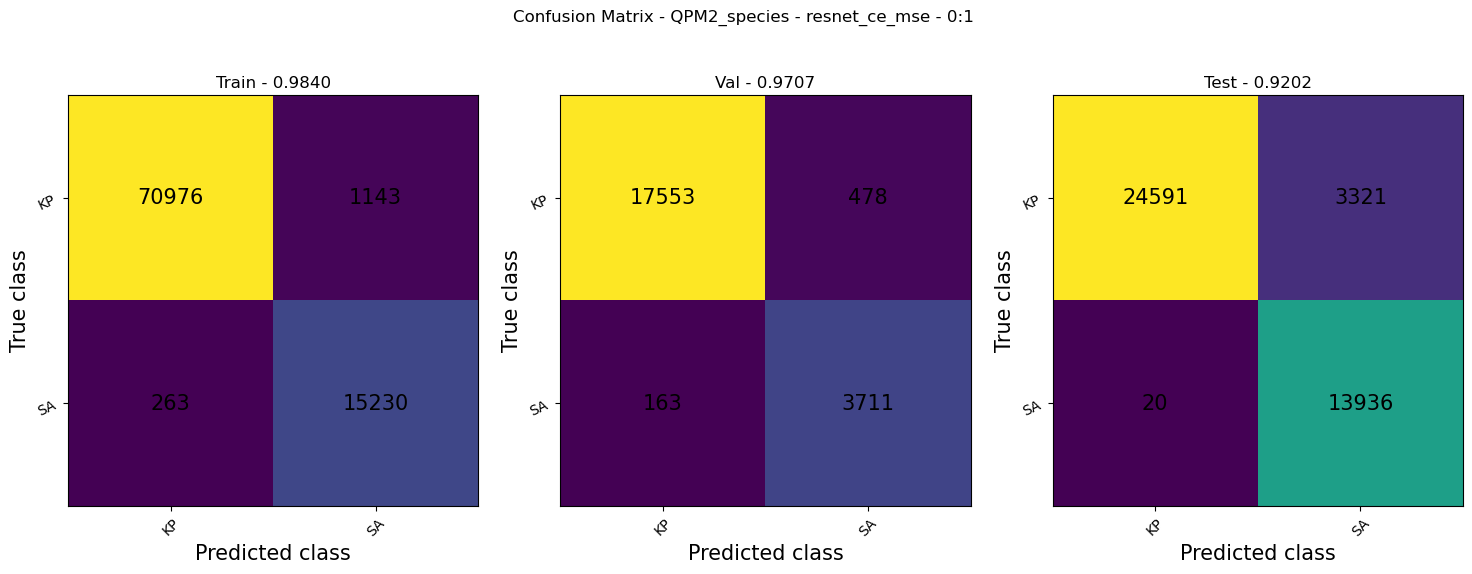

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

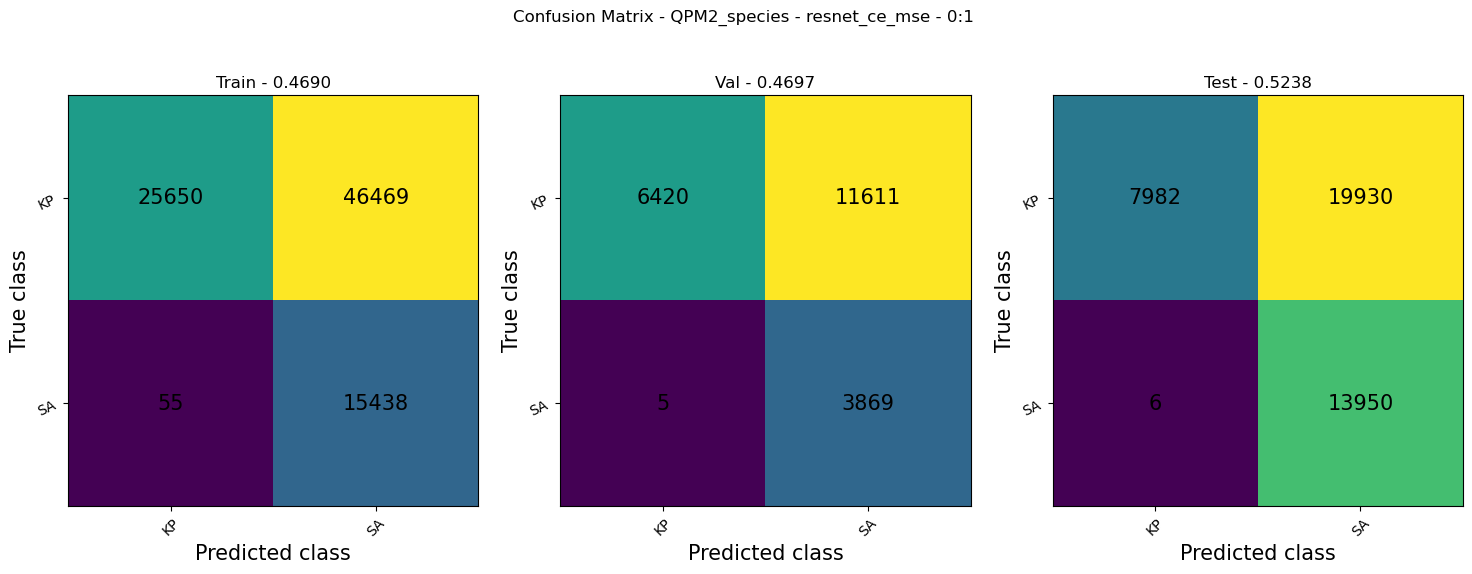

In [12]:
# compute test set accuracy - FPI
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(ftrain_acc=train_acc, fval_acc=val_acc, ftest_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [13]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(41868, 2) (55824, 2)
(41868, 2) (55824, 2)


In [14]:
# create 2d embeddings - FPI
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb_fpi2d = umap.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    all_lgt_fpi2d = umap.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(41868, 2) (55824, 2)
(41868, 2) (55824, 2)


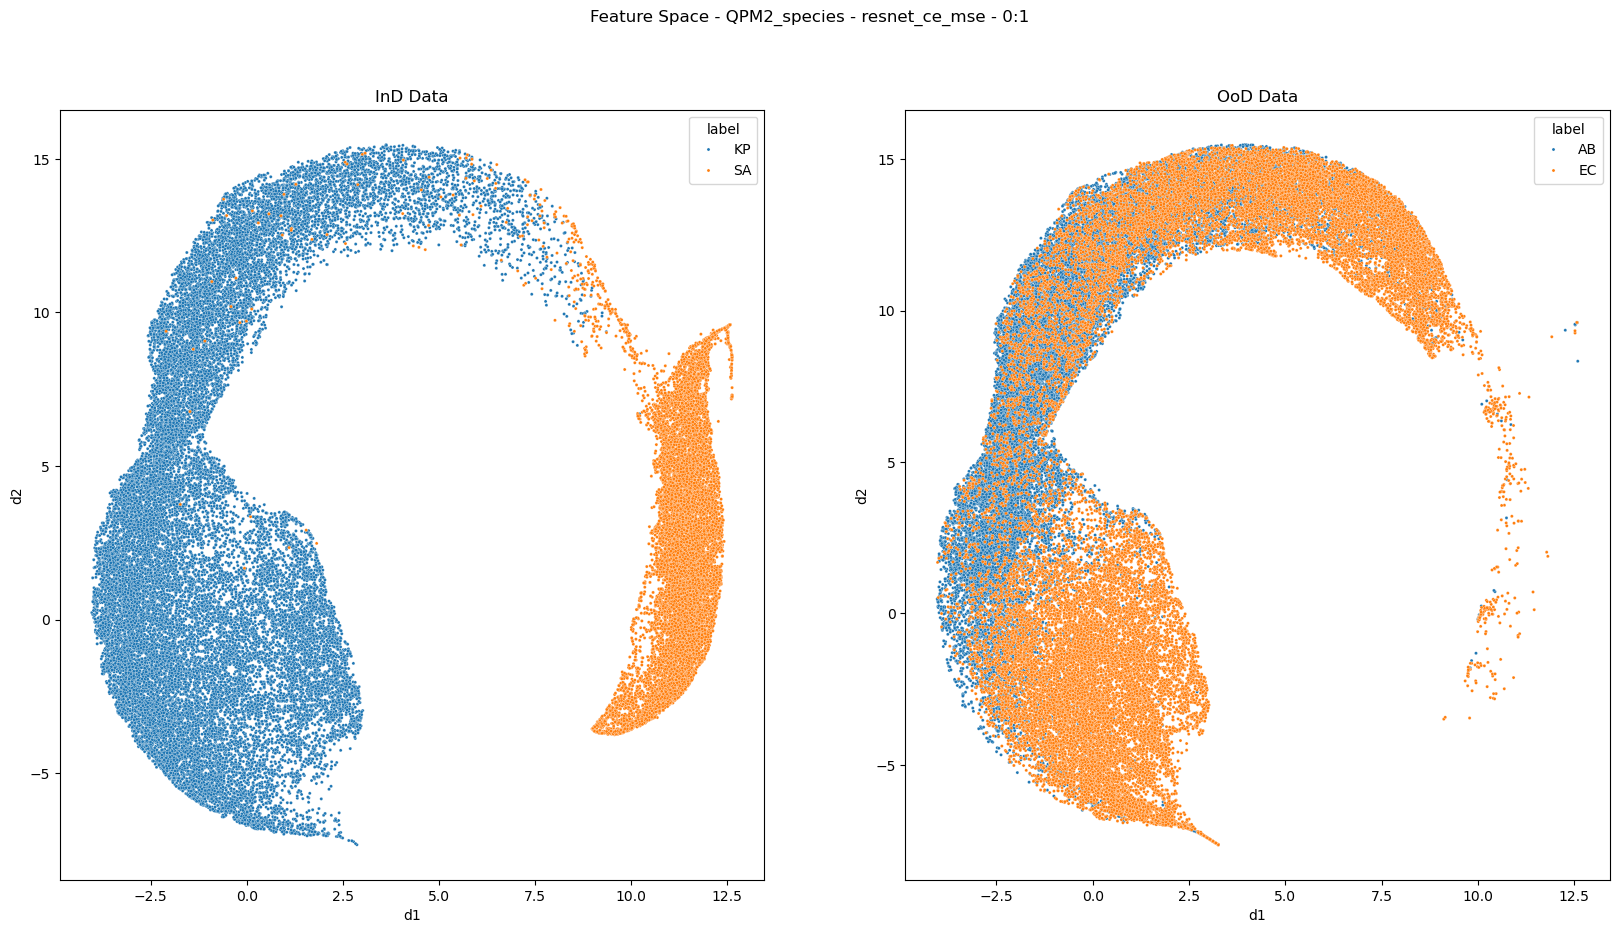

In [15]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

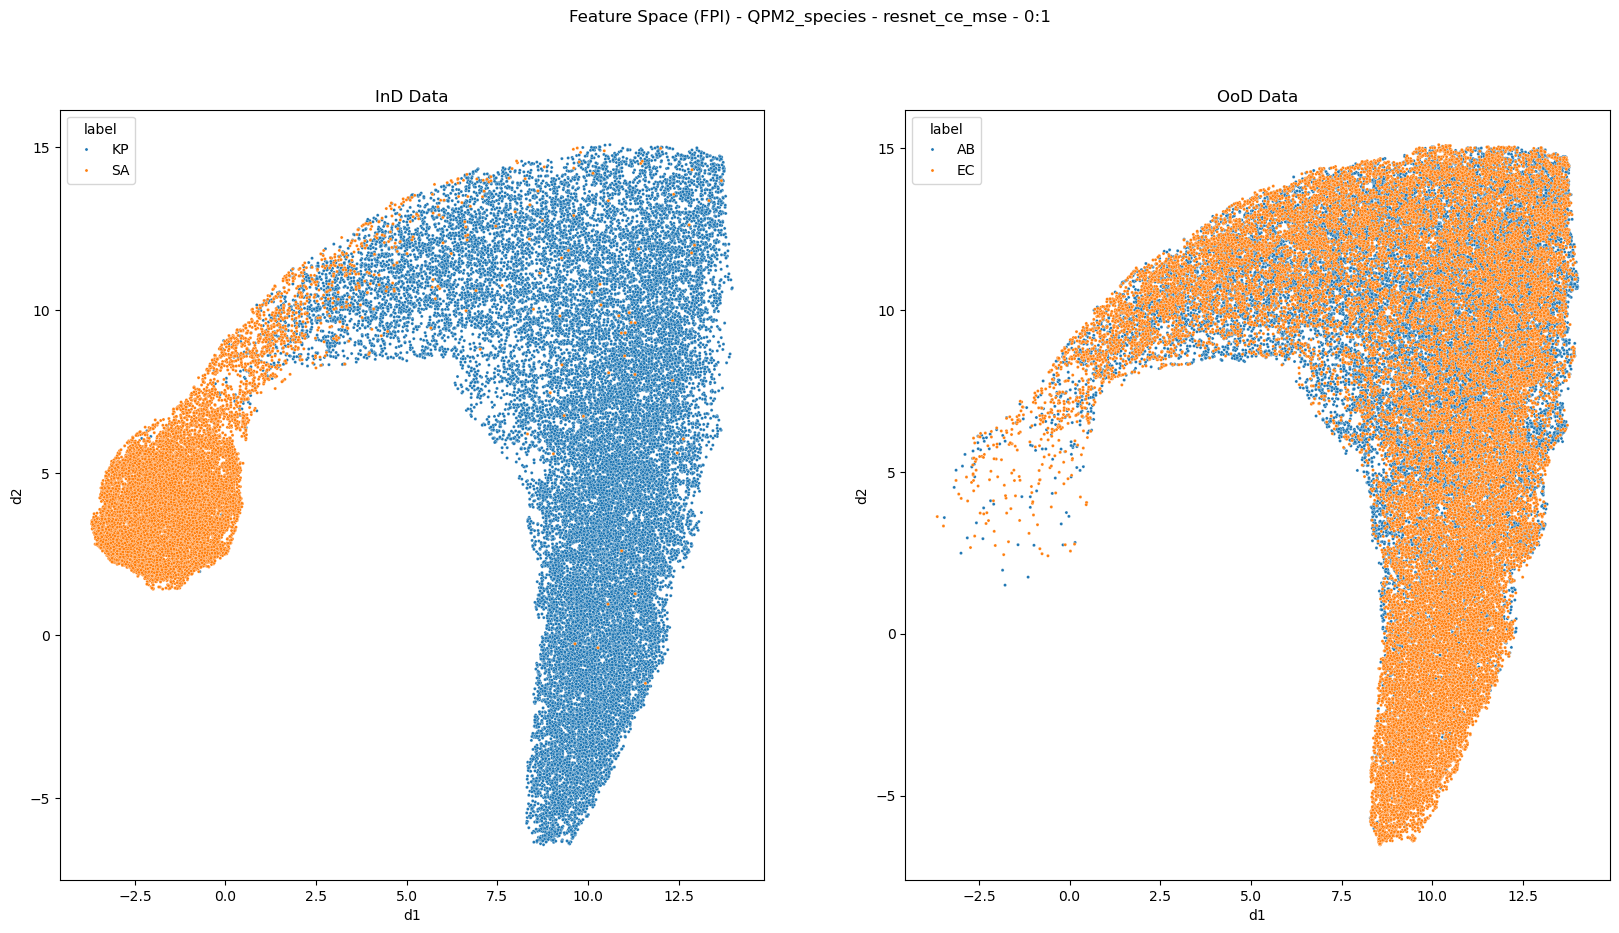

In [16]:
# plot feature space - FPI
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

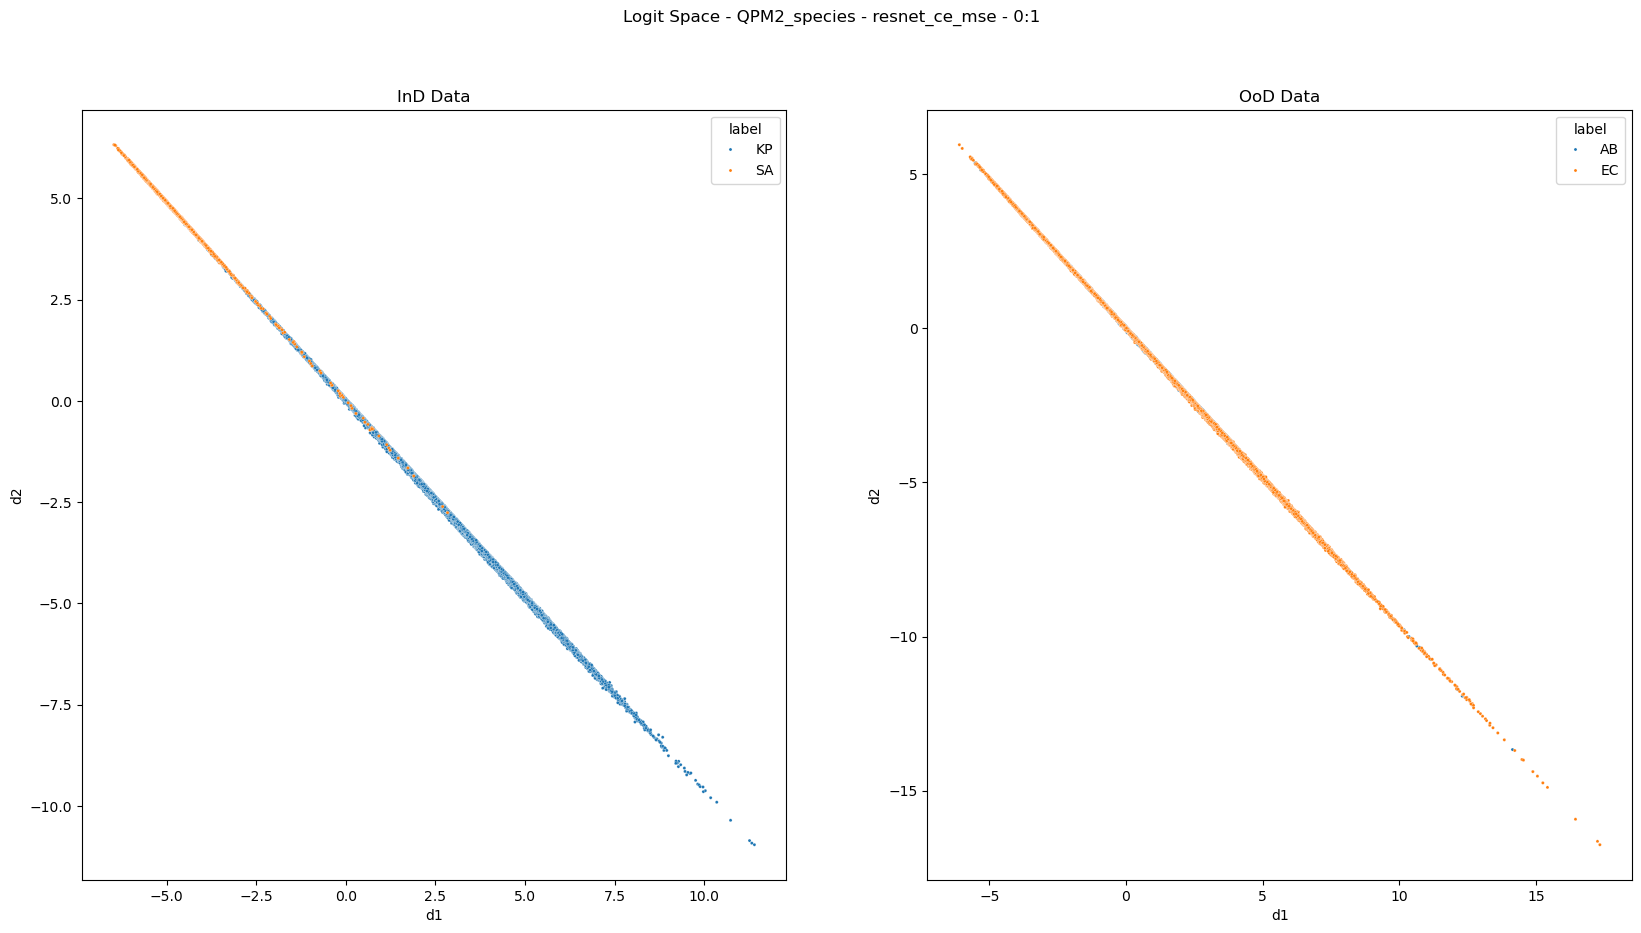

In [17]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

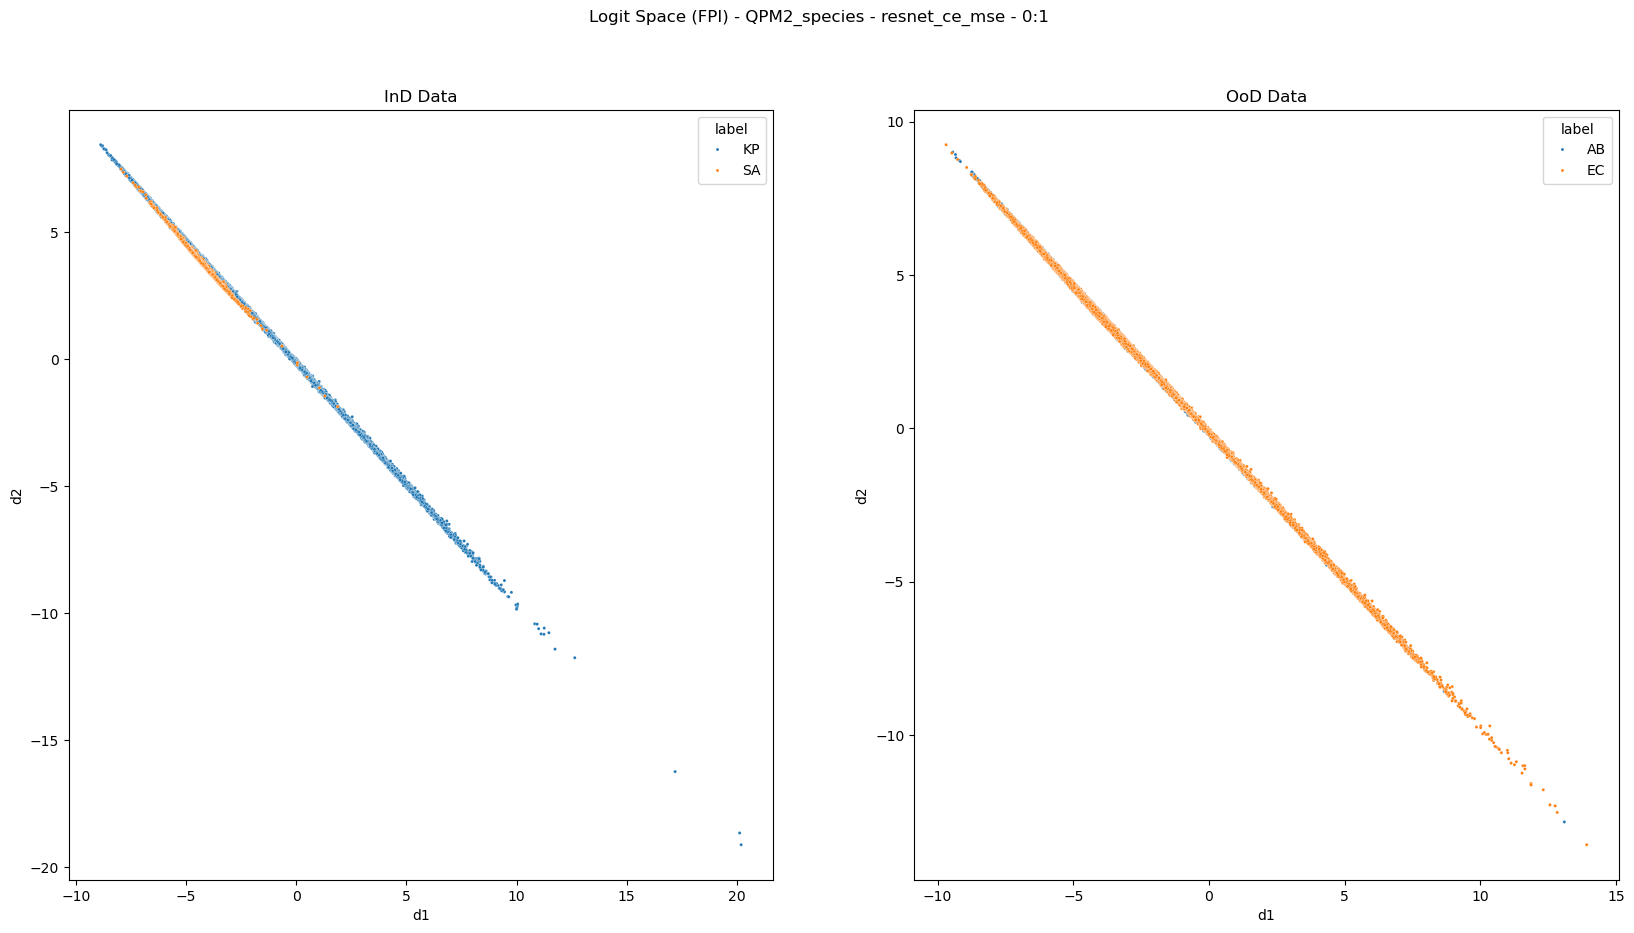

In [18]:
# plot logit space - FPI
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

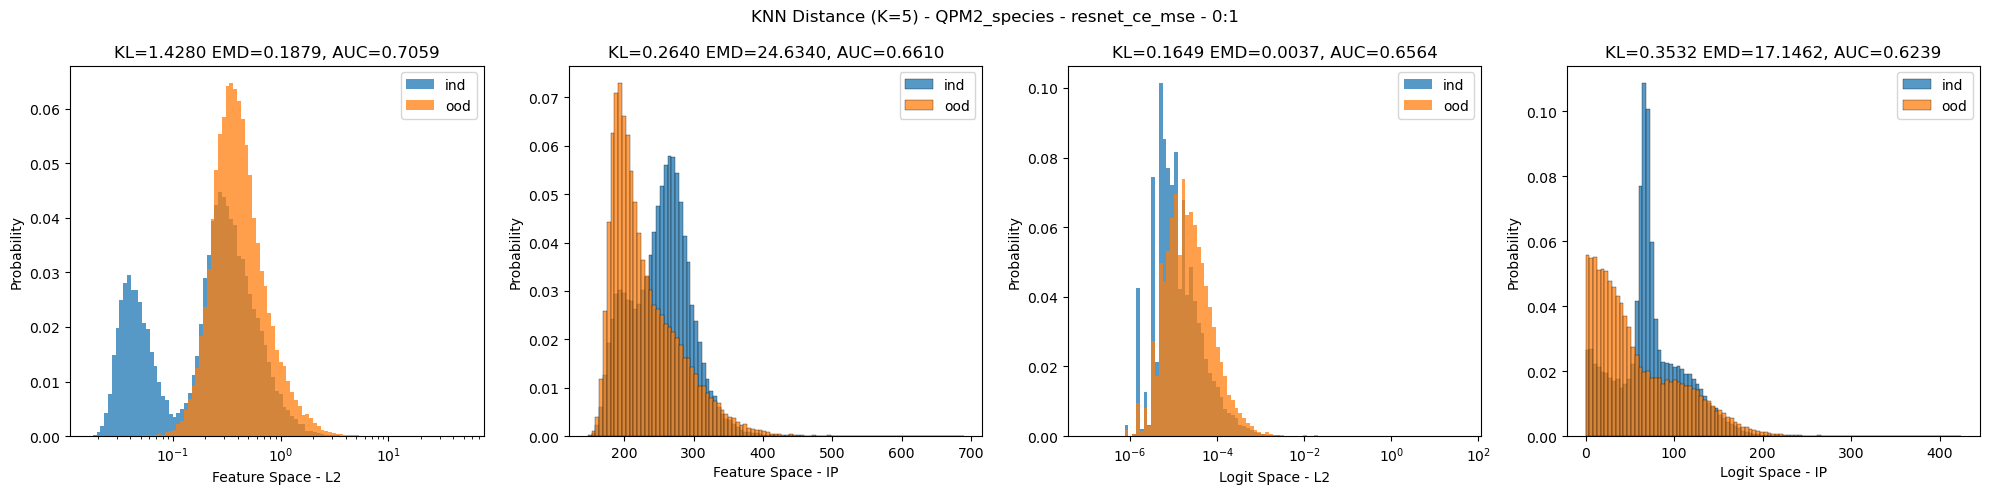

In [19]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats


fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

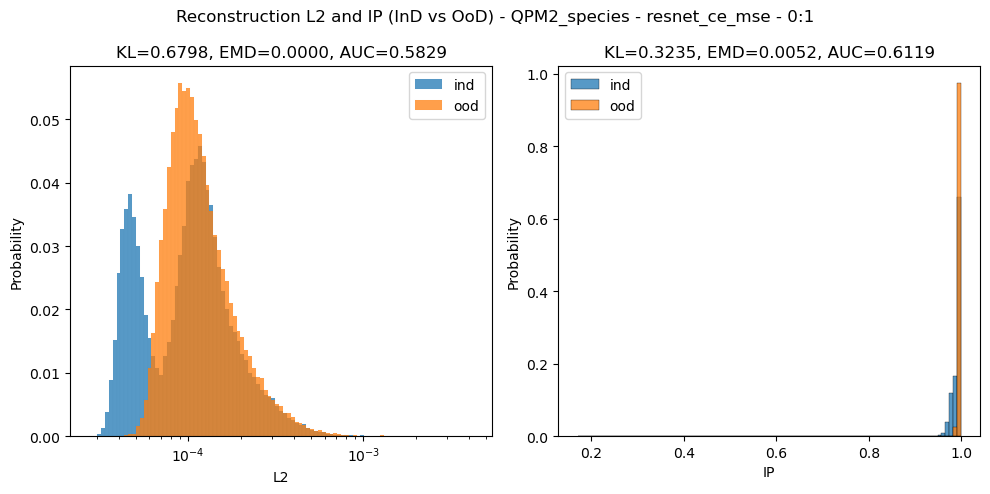

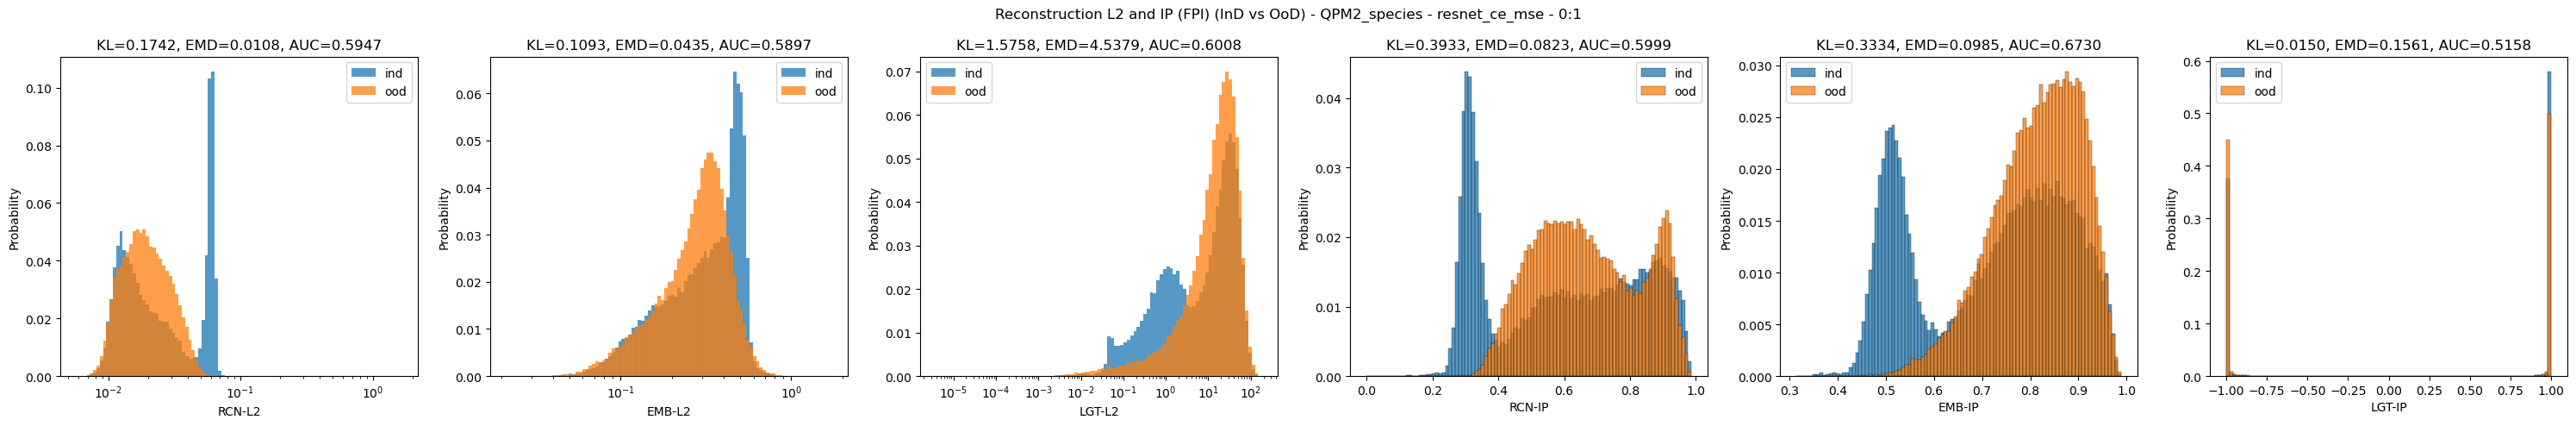

In [20]:
# plot reconstruction-based ood metrics
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# validation data
_val_inp = flatten(val_inp)
_val_rcn, _val_emb, _val_lgt = flatten(val_rcn), flatten(val_emb), flatten(val_lgt)
_val_rcn_fpi, _val_emb_fpi, _val_lgt_fpi = flatten(val_rcn_fpi), flatten(val_emb_fpi), flatten(val_lgt_fpi)
_val_inp_unit = unit(_val_inp)
_val_rcn_unit, _val_emb_unit, _val_lgt_unit = unit(_val_rcn), unit(_val_emb), unit(_val_lgt)
_val_rcn_fpi_unit, _val_emb_fpi_unit, _val_lgt_fpi_unit = unit(_val_rcn_fpi), unit(_val_emb_fpi), unit(_val_lgt_fpi)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)
val_rcn_l2_fpi = ((_val_inp - _val_rcn_fpi) ** 2).mean(-1)
val_emb_l2_fpi = ((_val_emb - _val_emb_fpi) ** 2).mean(-1)
val_lgt_l2_fpi = ((_val_lgt - _val_lgt_fpi) ** 2).mean(-1)
val_rcn_ip_fpi = (_val_inp_unit * _val_rcn_fpi_unit).sum(-1)
val_emb_ip_fpi = (_val_emb_unit * _val_emb_fpi_unit).sum(-1)
val_lgt_ip_fpi = (_val_lgt_unit * _val_lgt_fpi_unit).sum(-1)

# ind test data
_ind_inp = flatten(ind_inp)
_ind_rcn, _ind_emb, _ind_lgt = flatten(ind_rcn), flatten(ind_emb), flatten(ind_lgt)
_ind_rcn_fpi, _ind_emb_fpi, _ind_lgt_fpi = flatten(ind_rcn_fpi), flatten(ind_emb_fpi), flatten(ind_lgt_fpi)
_ind_inp_unit = unit(_ind_inp)
_ind_rcn_unit, _ind_emb_unit, _ind_lgt_unit = unit(_ind_rcn), unit(_ind_emb), unit(_ind_lgt)
_ind_rcn_fpi_unit, _ind_emb_fpi_unit, _ind_lgt_fpi_unit = unit(_ind_rcn_fpi), unit(_ind_emb_fpi), unit(_ind_lgt_fpi)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)

if ood_str:
    # ood test data    
    _ood_inp = flatten(ood_inp)
    _ood_rcn, _ood_emb, _ood_lgt = flatten(ood_rcn), flatten(ood_emb), flatten(ood_lgt)
    _ood_rcn_fpi, _ood_emb_fpi, _ood_lgt_fpi = flatten(ood_rcn_fpi), flatten(ood_emb_fpi), flatten(ood_lgt_fpi)
    _ood_inp_unit = unit(_ood_inp)
    _ood_rcn_unit, _ood_emb_unit, _ood_lgt_unit = unit(_ood_rcn), unit(_ood_emb), unit(_ood_lgt)
    _ood_rcn_fpi_unit, _ood_emb_fpi_unit, _ood_lgt_fpi_unit = unit(_ood_rcn_fpi), unit(_ood_emb_fpi), unit(_ood_lgt_fpi)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()


fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))
run_stats["frcn_l2"] = plot_rcn(val_rcn_l2_fpi, ind_rcn_l2_fpi, ood_rcn_l2_fpi if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("RCN-L2")
run_stats["femb_l2"] = plot_rcn(val_emb_l2_fpi, ind_emb_l2_fpi, ood_emb_l2_fpi if ood_str else None, ax2, scale="logspace")
ax2.set_xlabel("EMB-L2")
run_stats["flgt_l2"] = plot_rcn(val_lgt_l2_fpi, ind_lgt_l2_fpi, ood_lgt_l2_fpi if ood_str else None, ax3, scale="logspace")
ax3.set_xlabel("LGT-L2")
run_stats["frcn_ip"] = plot_rcn(val_rcn_ip_fpi, ind_rcn_ip_fpi, ood_rcn_ip_fpi if ood_str else None, ax4, scale="linspace")
ax4.set_xlabel("RCN-IP")
run_stats["femb_ip"] = plot_rcn(val_emb_ip_fpi, ind_emb_ip_fpi, ood_emb_ip_fpi if ood_str else None, ax5, scale="linspace")
ax5.set_xlabel("EMB-IP")
run_stats["flgt_ip"] = plot_rcn(val_lgt_ip_fpi, ind_lgt_ip_fpi, ood_lgt_ip_fpi if ood_str else None, ax6, scale="linspace")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"Reconstruction L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

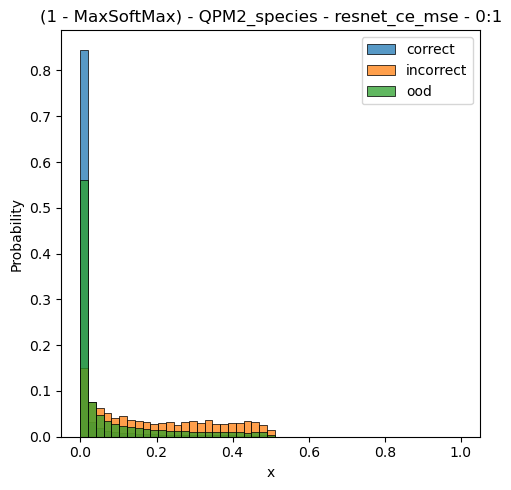

In [21]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

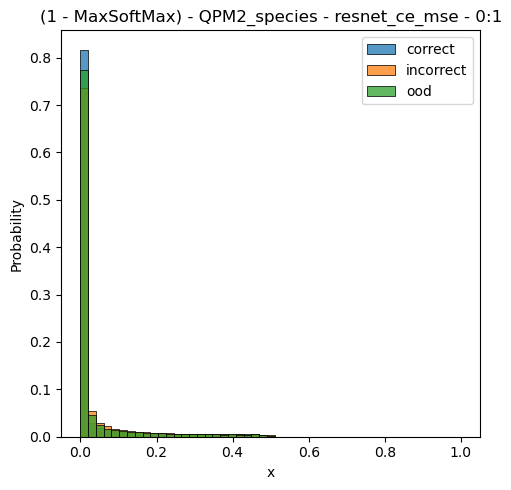

In [22]:
# plot (1 - maxsoftmax) distribution - FPI
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [23]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import gzip
import pickle
with gzip.open(f"{save_name}_stats.gz", "wb") as f:
    pickle.dump(run_stats, f)